## MSDS 7331 Data Mining: Project 2

***  

Team: Andrew Abbott, Vivek Bejugama, Patrick McDevitt, Preeti Swaminathan



***
	
We are using an online news popularity dataset from the UCI Machine Learning Repository. The dataset is a collection of 61 heterogeneous features for approximately 40,000 articles published by Mashable (www.mashable.com). The features are not the articles, but are extracted from the articles, such as word counts, title word counts, and keyword associations.  The data represents a two year period of published articles, ending in January 2015.  

We intend to mine this data to understand what parameters can influence an article to be shared on social media more than others.  The goal is to predict the number of shares in social networks (popularity).  

The business use of this data set / data mining project is ultimately to establish relationships that enable to predict how many social media shares an article published on _www.mashable.com_ is likley to generate - with the idea that a more socially shared article has higher business value - increasing traffic to the site, and consequently, potential for higher earnings revenue associated to the increased web traffic. The user of this model is both the publishers for _mashable.com_ for article selection, and also for authors, attempting to create content that has higher value on sites like _mashable.com_.  

Measures for a successful outcome from a predictive model for this study will be based on overall accuracy metrics (e.g., confusion matrix), as well as AUC type metrics. A baseline (non-predictive, random) scoring will establish a baseline for these metrics, and then the predictive model can be assessed against a random model for measurement of improvement, i.e., value of the model.  

The data is located at https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity  

***  
__Citation Request__ :  
***  
K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision Support System for Predicting the Popularity of Online News. Proceedings of the 17th EPIA 2015 - Portuguese Conference on Artificial Intelligence, September, Coimbra, Portugal.  
***  


- The data set has features in these 6 broad categories :  
_(ref - see citation reference at beginning of this document)_  
    - Words  
        - Number of words of the title/content  
        - Average word length  
        - Rate of unique/non-stop words of contents
    - Links
        - Number of links  
        - Number of links to other articles in Mashable  
    - Digital Media  
        - Number of images/videos  
    - Time  
        - Day of the week/weekend  
    - Keywords  
        - Number of keywords  
        - Worst/best/average keywords (#shares)  
        - Article category  
    - NLP  
        - Closeness to five LDA topics  
        - Title/Text polarity/subjectivity  
        - Rate and polarity of positive/negative words  
        - Absolute subjectivity/polarity level  
     




## Classification Model Development - Overview  

#### The request for this project includes 2 different classification tasks and (at least) the development and interpretation of 3 different classification models. This section is provided as an overview of the structure of the model development that was employed for both tasks, and for each classifier evaluation. Due to the length of this report, this section is provided as an aid to follow the logic employed throughout this report.

#### The report includes 2 classification tasks :  

 1.0 - Prediction of article popularity for articles proposed for publication on _mashable.com_  web-site. This is binary prediction model (popular / not-popular). This was the original intention of the development of this dataset.  
 2.0 - Assignment of article to appropriate __data_channel__. This is additional task developed by this team, in fulfillment of additional use of data set to provide an appropriate business use. In this case, the problem is a multi-classifier problem, to identify to which of 7 data channels (e.g., World, Entertainment, Business, Technology, ...) an article is most appropriate.  
 
#### This report includes 4 classifier models for each of the above 2 classification tasks :  

 1. - Logistic Regression  
 2. - Decision Tree  
 3. - Random Forest  
 4. - Naïve Bayes  
 
#### The model development approach in all cases is as described here below :

1.	**Holdout** 20% of data set for final sacred test set

2.	Split remaining 80% into train / test for grid search  

3.	Run **Grid Search with CV 3** on each classification type  
    a.	Search on range of model parameters with cross-validation iteration of 3  

4.	Identify best accuracy / best parameters from **Grid Search**
    a.	Run each classifier model with best parameters for later **10-fold CV** verification  
    b.	Verify results are consistent with grid search model results

5.	Run full **10-fold CV** with the best parameters for each classifier
    a.	Verify results are consistent with prior grid search results  
    b.	Evaluate the 10-fold CV on model metrics (in our case Accuracy)

6.	Identify best overall model from the 4 classifiers after 10-fold CV  

7.	 Run best overall model on **Holdout** 20% sacred data set  
    a.	Report results from this test set run as expected model capability  

8.	Identify **feature importance** from each of the 4 classifier models (best model each)    
    a.	Consider if feature scaling is beneficial for interpretation  

9.	Identify strengths / weakness of model prediction capability (e.g., some classes well predicted or not)

 <img src = '../proj_02/model_development_method.png'>

#### Import required packages  


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter('ignore',DeprecationWarning)
import seaborn as sns
import time

from pylab import rcParams
#import hdbscan

from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

#from sklearn.datasets import make_blobs

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn import metrics as mt
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix as conf
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

from tabulate import tabulate

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### Read in dataset from .csv file  

In [3]:
data_dir = '../data/'
data_file = 'OnlineNewsPopularity.csv'

file_2_read = data_dir + data_file
df = pd.read_csv(file_2_read)  

In [4]:
df.columns = df.columns.str.strip()
col_names = df.columns.values.tolist()


# Data Preparation Part 1	

### Task 1 data set definition  

 - For Task 1 we intend to mine this data to understand what parameters can influence an article to be shared on social media more than others.  The goal is to predict the number of shares in social networks (popularity). 
 - The business use of this data set / data mining project is ultimately to establish relationships that enable to predict how many social media shares an article published on _www.mashable.com_ is likley to generate - with the idea that a more socially shared article has higher business value - increasing traffic to the site, and consequently, potential for higher earnings revenue associated to the increased web traffic. The user of this model is both the publishers for _mashable.com_ for article selection, and also for authors, attempting to create content that has higher value on sites like _mashable.com_.   
 - In order to support this classification task, we create a new dependent variable column __popular__  which is true if the value of __shares__ is greater than 1400.

#### Remove variables that are not useful

In [5]:
popular_binary = np.where(df['shares'] > 1400, True, False)

df.insert(loc = 0, column = 'popular', value = popular_binary)

del df['shares'] 

In [7]:
del df['n_non_stop_words']
del df['n_non_stop_unique_tokens']
del df['n_unique_tokens']
del df['url']

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
timedelta,39644.0,354.530471,214.163767,8.00000,164.000000,339.000000,542.000000,731.000000
n_tokens_title,39644.0,10.398749,2.114037,2.00000,9.000000,10.000000,12.000000,23.000000
n_tokens_content,39644.0,546.514731,471.107508,0.00000,246.000000,409.000000,716.000000,8474.000000
num_hrefs,39644.0,10.883690,11.332017,0.00000,4.000000,8.000000,14.000000,304.000000
num_self_hrefs,39644.0,3.293638,3.855141,0.00000,1.000000,3.000000,4.000000,116.000000
num_imgs,39644.0,4.544143,8.309434,0.00000,1.000000,1.000000,4.000000,128.000000
num_videos,39644.0,1.249874,4.107855,0.00000,0.000000,0.000000,1.000000,91.000000
average_token_length,39644.0,4.548239,0.844406,0.00000,4.478404,4.664082,4.854839,8.041534
num_keywords,39644.0,7.223767,1.909130,1.00000,6.000000,7.000000,9.000000,10.000000
data_channel_is_lifestyle,39644.0,0.052946,0.223929,0.00000,0.000000,0.000000,0.000000,1.000000


#### Assign certain variables to type integer, as appropriate

In [9]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  convert the data type to Integer
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

to_int = ['timedelta','n_tokens_title', 'n_tokens_content',
    'num_hrefs','num_self_hrefs', 'num_imgs', 'num_videos', 'num_keywords',
    'weekday_is_monday',
    'weekday_is_tuesday',
    'weekday_is_wednesday',
    'weekday_is_thursday',
    'weekday_is_friday',
    'weekday_is_saturday',
    'weekday_is_sunday',
    'is_weekend']
    

df[to_int] = df[to_int ].astype(np.int64)

In [10]:
df[df.duplicated()]

,popular,timedelta,n_tokens_title,n_tokens_content,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity


#### Impute kw_avg_max for 0-values and re-scale to standard normal scale

 - A small number of rows have 0 value for __kw_avg_max__, which is completely out of range for the remaining rows of this variable.    
 - We will impute these rows to median value of the column  
 
 - The magnitude of this column of data is markedly different than the range of values in the remaining columns in the data set. To bring this back in line, we will re-scale the values in this column to standard normal range

In [11]:

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  impute to median value for a few rows of kw_avg_max
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

condition = df['kw_avg_max'] == 0
df.loc[condition, 'kw_avg_max'] = df.kw_avg_max.median()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  scale to standard normal scale
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df.kw_avg_max = (df.kw_avg_max - df.kw_avg_max.mean()) / df.kw_avg_max.std()


244572.22222250002

244575.00000025

#### Constant offset for variables with min value < 0  

 - This allows to consider these variables for ln() transform if highly right-skewed and also supports some classification models that only accept independent variables that are > 0  
 - Method here is to just add -1 * min_value of any column for which min_value < 0

In [12]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  for all columns with negative values, add +1 to all values in the column
# ...  - the only columns with negative values are polarity / sentiment measures
# ...  - adding a constant to all values does not modify distributions
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_numeric = df.select_dtypes(['number'])
numeric_col_names = df_numeric.columns.values.tolist()

# ... store min value for each column

df_mins = df.min()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  loop on each column, test for min < 0, add constant as applicable
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

for column in numeric_col_names :
    if df_mins[column] < 0 :
        df[column] = df[column] - df_mins[column]
        
#        print('--> min_value < 0 adjusted : ', column, df_mins[column])

#### Ln() transform for variables that are right skewed (skewness > 1)  

 - This facilitiates maintaining more normally distributed residuals for regression models  
 - Likely, this will not be needed for the classification task, at present, but also does not have negative effects for this current activity


In [13]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  ln() transform right skewed distribution variables (skewness > 1)
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_numeric = df.select_dtypes(['number'])

numeric_col_names = df_numeric.columns.values.tolist()

# ... store min value for each column

df_mins = df.min()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  loop on each column, test for skewness, create new column if conditions met
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

columns_to_drop = []

for column in numeric_col_names:
    sk = df[column].skew()
    
    if(sk > 1):
        new_col_name = 'ln_' + column
        print (column, sk, new_col_name)
        
        if df_mins[column] > 0:
            df[new_col_name] = np.log(df[column])
            columns_to_drop.append(column)
            
        elif df_mins[column] == 0:
            df_tmp = df[column] + 1
            df[new_col_name] = np.log(df_tmp)
            columns_to_drop.append(column)
            
        else:
            print('--> Ln() transform not completed -- skew > 1, but min value < 0 :', column, '!!')
            
            
# ... delete tmp data

del df_tmp
del df_mins
del df_numeric

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  based on inspection, a few of these are just not valid ranges in ln() space
# ...  -- just delete these few back out of the data set
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

print (columns_to_drop)

del df['ln_LDA_00']
del df['ln_LDA_01']
del df['ln_LDA_02']
del df['ln_LDA_03']
del df['ln_LDA_04']
columns_to_drop.remove('LDA_00')
columns_to_drop.remove('LDA_01')
columns_to_drop.remove('LDA_02')
columns_to_drop.remove('LDA_03')
columns_to_drop.remove('LDA_04')

# ...  these are binary indicators ... so no need to ln-transform

del df['ln_weekday_is_monday']
del df['ln_weekday_is_tuesday']
del df['ln_weekday_is_wednesday']
del df['ln_weekday_is_thursday']
del df['ln_weekday_is_friday']
del df['ln_weekday_is_saturday']
del df['ln_weekday_is_sunday']
del df['ln_is_weekend']
columns_to_drop.remove('is_weekend')
columns_to_drop.remove('weekday_is_monday')
columns_to_drop.remove('weekday_is_tuesday')
columns_to_drop.remove('weekday_is_wednesday')
columns_to_drop.remove('weekday_is_thursday')
columns_to_drop.remove('weekday_is_friday')
columns_to_drop.remove('weekday_is_saturday')
columns_to_drop.remove('weekday_is_sunday')

#columns_to_drop.remove('data_channel')

print ('\n-----------------------------------\n')
print ('Number of current columns in dataset :', len(df.columns))

df.drop(columns_to_drop, axis = 1, inplace = True)

#df.info()


n_tokens_content 2.94542193879 ln_n_tokens_content
num_hrefs 4.0134948282 ln_num_hrefs
num_self_hrefs 5.17275110576 ln_num_self_hrefs
num_imgs 3.94659584465 ln_num_imgs
num_videos 7.0195327863 ln_num_videos
data_channel_is_lifestyle 3.99301914336 ln_data_channel_is_lifestyle
data_channel_is_entertainment 1.6835848094 ln_data_channel_is_entertainment
data_channel_is_bus 1.87687018599 ln_data_channel_is_bus
data_channel_is_socmed 3.75887963097 ln_data_channel_is_socmed
data_channel_is_tech 1.61997576469 ln_data_channel_is_tech
data_channel_is_world 1.40516938412 ln_data_channel_is_world
kw_min_min 2.37494728018 ln_kw_min_min
kw_max_min 35.3284337312 ln_kw_max_min
kw_avg_min 31.3061081027 ln_kw_avg_min
kw_min_max 10.3863716348 ln_kw_min_max
kw_max_avg 16.4116695554 ln_kw_max_avg
kw_avg_avg 5.76017729162 ln_kw_avg_avg
self_reference_min_shares 26.2643641603 ln_self_reference_min_shares
self_reference_max_shares 13.8708490494 ln_self_reference_max_shares
self_reference_avg_sharess 17.914093

# Data Preparation Part 2

#### Data Selection - Task 1 - Popularity classification

- There are 60 columns in the original data set; we added an additonal column based on the value of shares as explained above. 
    
- From this data set, we did a simple correlation matrix to look for variables that are highly correlated with each other that could be removed with little loss of information.

- With that downselection, we proceeded with additional evaluation of these remaining variables.
    
- we recognize that there is likely significant additional opportunity for modeling improvements with many of the remaining variables, and will look to re-expand the data set to further consider that with future work.  

In [14]:

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... display highest correlation pairs from corr() matrix 
# ...
# ... https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_numeric = df.select_dtypes(['number'])

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n = 5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels = labels_to_drop).sort_values(ascending = False)
    return au_corr[0:n]

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... list out Top30 correlations
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

n_val = 30

top_30_corr_list = get_top_abs_correlations(df_numeric, n_val)
print("\n\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
print("Top Absolute Correlations\n")
print(top_30_corr_list)


icor = 0
drop_column = list()
while (top_30_corr_list[icor] > 0.65):
    drop_column.append(top_30_corr_list[top_30_corr_list == top_30_corr_list[icor]].index[0][0])
    icor += 1

drop_column = list(set(drop_column))

print("\n\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
print("Columns Recommended for removal based on correlation > 0.65")
print("-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-\n")

print("\n".join(sorted(drop_column)))

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... drop one of the high correlation columns (2nd of the pair)
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df = df.drop(drop_column, axis = 1)

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... show correlation test with remaining, to confirm
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_reduced_numeric = df.select_dtypes(['number'])

top_30_corr_list = get_top_abs_correlations(df_reduced_numeric, n_val)

print("\n\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
print("\n\nTop Absolute Correlations (2nd Pass)\n")
print(top_30_corr_list)




-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Top Absolute Correlations

ln_self_reference_max_shares  ln_self_reference_avg_sharess       0.994639
ln_self_reference_min_shares  ln_self_reference_avg_sharess       0.971014
ln_kw_max_min                 ln_kw_avg_min                       0.946087
ln_self_reference_min_shares  ln_self_reference_max_shares        0.945943
kw_min_avg                    ln_kw_min_max                       0.926784
ln_kw_max_avg                 ln_kw_avg_avg                       0.899409
LDA_02                        ln_data_channel_is_world            0.836618
timedelta                     ln_kw_min_min                       0.822783
kw_max_max                    ln_kw_min_min                       0.820625
rate_negative_words           ln_global_rate_negative_words       0.782517
LDA_00                        ln_data_channel_is_bus              0.774651
average_token_length          ln_n_tokens_content                 0.768795
LDA_04       

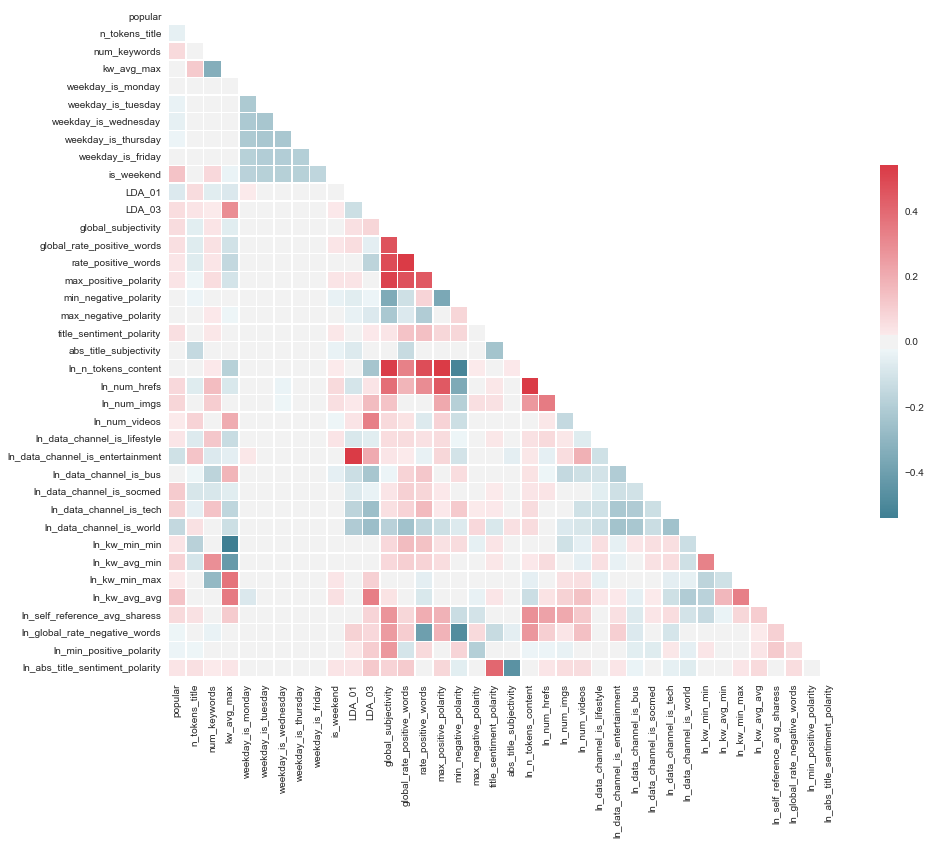

In [15]:
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 13))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


# from example found at https://www.kaggle.com/maheshdadhich/strength-of-visualization-python-visuals-tutorial/notebook

#### Save cleaned / reduced data set to external .csv file  

 - This provides opportunity to just read in this .csv file and no need to repeat data cleaning / reduction process for each execution  
 

In [17]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... store in ../data/ directory
# ... write as .csv file for future recall
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

data_dir = '../data/'
data_file = 'mashable_clean_dataset_for_lab_02_task_01.csv'

file_2_write = data_dir + data_file

df.to_csv(file_2_write, index = False)


# 	Modeling and Evaluation 2

### Holdout, Training and Test split

In [18]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  copy data frame to classification working data frame
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

# ... data set with text categorical target values 

df_pop = df.copy()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  separate X and y matrices 
# ...
# ...  convert to numpy matrices by calling 'values' on the pandas data frames
# ...  they are now simple matrices for compatibility with scikit-learn
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

if 'popular' in df_pop:
    y = df_pop['popular'].values         # set 'popular as dependent
    del df_pop['popular']                 # remove from dataset
    X = df_pop.values                        # use everything else for independent EVs

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  setup master train and test , golden traina and test
# ...  master sets - first 80% of original data set which will be base training for model building
# ...  Golden sets - 20% of original will be used in the final best model for prediction
# ...  split into training and test sets
# ....  --> 10 folds
# ...   --> 80% / 20% training / test
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=




In [19]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... Set-up golden test data set
# ... This data-set will be used to evaluate the predictive capability of the final
# ... model on a data set that was not included in any of the prior train/test sets
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

num_cv_iterations = 1
cv_object = ShuffleSplit(n_splits = num_cv_iterations,
                         test_size  = 0.2)
                        
print(cv_object)

for train_indices, test_indices in cv_object.split(X, y):
    master_X_train = X[train_indices]
    master_y_train = y[train_indices]    
    golden_X_test  = X[test_indices]
    golden_y_test  = y[test_indices]
    print(master_X_train.shape)


ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=None)
(31715, 37)


In [20]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... Set-up training set to be used on 'best' model from grid search results
# ... This data-set will be used to verify 10-fold-CV-model has results consistent
# ... with the model produced from grid search
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

num_cv_iterations = 1
cv_object = ShuffleSplit(n_splits = num_cv_iterations,
                         test_size  = 0.2)
                        
print(cv_object)

for train_indices, test_indices in cv_object.split(master_X_train, master_y_train):
    X_train = master_X_train[train_indices]
    y_train = master_y_train[train_indices]    
    X_test  = master_X_train[test_indices]
    y_test  = master_y_train[test_indices]
    print(X_train.shape)


ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=None)
(25372, 37)


In [21]:
# set required variables for model comparison

comparison_tbl = pd.DataFrame(columns = [
    'Model Name',
    'Accuracy',
    'Precision',
    'Recall',
    'FScore',
    'Processing Time'])

i_index=[]
i_index = 0

# preparation for cross validation and model comparison, each classifier is appended once model is fit

models = []

# 	Modeling and Evaluation 3	

For task 1 we have chosen the following 4 models:<br>
a. Binary logistic regression with parament selection using Grid Search<br>
b. Decision Tree with parament selection using Grid Search<br>
c. Random Forest with parament selection using Grid Search<br>
d. Naive Bayes<br>

Each of these models will be evaluated on Accuracy, Precision, Recall, FScore and Execution time

### a. Linear logistic regression
For linear LR we have set standard attributes with:
    class_weight = balanced<br>
<b>search params:</b><br>
    tolerance parament tol<br>
    Regularization parament C<br>
    
    
#### _Grid selection for logistic regression_


In [22]:
from sklearn.grid_search import GridSearchCV

lr_model = LogisticRegression(
    class_weight = 'balanced',
    solver = 'lbfgs',
    C = 10,
    tol = 0.1)

params = {
    'C':[100, 1000], 
    'tol': [0.001, 0.0001]
}

# ... --> changed the scoring on Sat 28-Oct
# ...     - from : log_loss
# ...     - to : neg_log_loss
# ...  (this avoids the deprecation warning)

clf = GridSearchCV(
    lr_model,
    params,
    scoring = 'neg_log_loss',
    refit = 'True',
    n_jobs = -1,
    cv = 3)

grid_search = clf.fit(master_X_train, master_y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

best_C = best_parameters['C']
best_tol = best_parameters['tol']



/home/mcdevitt/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/mcdevitt/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


#### _Best parameter values for logistic regression_:

In [23]:
best_accuracy
best_parameters

-0.6455183007058597

{'C': 100, 'tol': 0.001}

#### Create main logistic model using best paraments for further analysis and model comparisons

In [24]:
tic = time.clock()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... basic Logistic Regression
# ... - normalize features based on mean & stdev of each column
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

lr_model1 = LogisticRegression(
    class_weight = 'balanced',
    solver = 'lbfgs',
    C = best_C,
    tol = best_tol)

lr_model1.fit(X_train, y_train)  # train object

y_hat = lr_model1.predict(X_test) # get test set predictions

toc =  time.clock()

# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(y_test, y_hat))
precision = '{0:.4f}'.format(metrics.precision_score(y_test, y_hat,average='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(y_test, y_hat,average='weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(y_test, y_hat,average='weighted'))

exetime = '{0:.4f}'.format(toc-tic)

# print statistics

print("accuracy",accuracy )
print("precision",precision )
print("recall",recall )
print("f1_score",f1_score )
print("confusion matrix\n", conf(y_test, y_hat))
print('process time',exetime)
print("\n")

# save statistics for model comparison

raw_data = {
    'Model Name' : 'Logistic Regression',
    'Accuracy' : accuracy,
    'Precision' : precision,
    'Recall' : recall,
    'FScore' : f1_score,
    'Processing Time' : exetime
}

df_tbl = pd.DataFrame(raw_data,
    columns = ['Model Name', 'Accuracy', 'Precision', 'Recall', 'FScore', 'Processing Time'],
    index = [i_index + 1])

comparison_tbl = comparison_tbl.append(df_tbl)

#append model classifier for cross-validation

models.append(('Logistic Regression', lr_model1))


LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.001, verbose=0, warm_start=False)

accuracy 0.6342
precision 0.6348
recall 0.6342
f1_score 0.6343
confusion matrix
 [[2034 1220]
 [1100 1989]]
process time 0.9443




### Interpreting Weights

In [30]:
# Interpreting weights
zip_vars = zip(sum(abs(lr_model1.coef_)).T,df_pop.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print('\t%-35s - weight = %9.3f' % (name, coef)) # now print them out

	ln_kw_min_max                       - weight =     0.004
	ln_data_channel_is_lifestyle        - weight =     0.015
	n_tokens_title                      - weight =     0.024
	ln_global_rate_negative_words       - weight =     0.025
	ln_self_reference_avg_sharess       - weight =     0.026
	num_keywords                        - weight =     0.028
	rate_positive_words                 - weight =     0.031
	ln_kw_min_min                       - weight =     0.032
	kw_avg_max                          - weight =     0.032
	abs_title_subjectivity              - weight =     0.049
	global_rate_positive_words          - weight =     0.056
	ln_kw_avg_min                       - weight =     0.060
	max_positive_polarity               - weight =     0.067
	ln_num_hrefs                        - weight =     0.099
	weekday_is_friday                   - weight =     0.107
	ln_num_videos                       - weight =     0.113
	title_sentiment_polarity            - weight =     0.135
	ln_num_imgs  

To interpret the weights of each variable, I used the sums of the absolute values of the coefficients of each variable for each class. Because a particular variable might be highly positively predictive of one class and highly negatively predictive of another class, their sums would appear to have little value. I sum the absolute values to measure the total predictive value across all classes.  

It does not surprise me to see that Social Media data channel is the most predictive, since social media by nature involves sharing with connections, followed by World data channel and positive polarity. Overall, data channels social media, world, and entertainment are more predictive of the popularity.

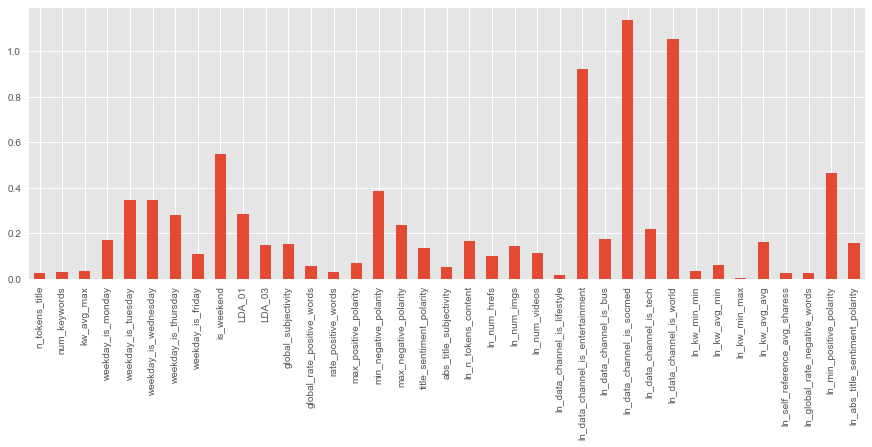

In [31]:
%matplotlib inline
rcParams['figure.figsize'] = 15, 5
plt.style.use('ggplot')

weights = pd.Series(sum(abs(lr_model1.coef_)), index = df_pop.columns)
weights.plot(kind = 'bar')
plt.show()

Above is a visual representaion of the magnitudes of the coefficients.

### b. Decision Tree Classifier using Grid Search
#### _Grid search parameter set-up_

In [37]:
# Applying Grid Search to find the best model and the best parameters

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

DTclassifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)

parameters = [
      {
        'criterion': ['gini'], 
        'max_depth': [None, 5, 10], 
        'min_samples_split': [2, 100, 1000], 
        'min_samples_leaf': [1, 10, 100],
        'max_features': [None],
        'max_leaf_nodes': [None]
      },
      {
          'criterion': ['entropy'], 
          'max_depth': [None, 5, 10], 
          'min_samples_split': [2, 100, 1000],
          'min_samples_leaf': [1, 10, 100], 
          'max_leaf_nodes': [None]
      }
     ]

grid_search = GridSearchCV(estimator = DTclassifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 3,
                           n_jobs = -1)

grid_search = grid_search.fit(master_X_train, master_y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

best_accuracy
best_parameters

best_criterion = best_parameters['criterion']
best_max_depth = best_parameters['max_depth']
best_max_leaf_nodes = best_parameters['max_leaf_nodes']
best_min_samples_leaf = best_parameters['min_samples_leaf']
best_min_samples_split = best_parameters['min_samples_split']


0.63752167743969734

{'criterion': 'entropy',
 'max_depth': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 10,
 'min_samples_split': 1000}

#### _Best parameters for Decision Tree_

In [38]:
best_accuracy
best_parameters

0.63752167743969734

{'criterion': 'entropy',
 'max_depth': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 10,
 'min_samples_split': 1000}

#### _use best parameters to create best Decision Tree model for further analysis and model comparison_

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,classification_report

tic = time.clock()

# train and fit

DTclassifier = DecisionTreeClassifier(
    criterion = best_criterion,
    min_samples_leaf = best_min_samples_leaf,
    min_samples_split = best_min_samples_split,
    max_leaf_nodes = best_max_leaf_nodes,
    max_depth = best_max_depth)

DTclassifier.fit(X_train, y_train)
y_predDT = DTclassifier.predict(X_test)

# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(y_test, y_predDT))
precision = '{0:.4f}'.format(metrics.precision_score(y_test, y_predDT,average='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(y_test, y_predDT,average='weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(y_test, y_predDT,average='weighted'))
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)

# print statistics
print("accuracy",accuracy )
print("precision",precision )
print("recall",recall )
print("f1_score",f1_score )
print("confusion matrix\n", confusion_matrix(y_test, y_predDT))
print('process time',exetime)
print("\n")

# save statistics for model comparison

raw_data = {
    'Model Name':'Decision Tree Classifier',
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'FScore':f1_score,
    'Processing Time': exetime
}

df_tbl = pd.DataFrame(raw_data,
        columns = ['Model Name','Accuracy','Precision','Recall','FScore','Processing Time'],
        index = [i_index + 1])

comparison_tbl = comparison_tbl.append(df_tbl)

#append model classifier for cross-validation

models.append(('Decision Tree Classifier', DTclassifier))


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=1000,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

accuracy 0.6346
precision 0.6353
recall 0.6346
f1_score 0.6327
confusion matrix
 [[2280  974]
 [1344 1745]]
process time 0.4662




### Interpretation of importances.

In [40]:
# Interpreting weights

zip_varsDT = zip(DTclassifier.feature_importances_.T,df_pop.columns) # combine attributes

zip_varsDT = sorted(zip_varsDT)

for importance, name in zip_varsDT:
    print('\t%-35s - weight = %9.3f' % ( name, importance)) # now print them out

	LDA_03                              - weight =     0.000
	abs_title_subjectivity              - weight =     0.000
	global_subjectivity                 - weight =     0.000
	ln_abs_title_sentiment_polarity     - weight =     0.000
	ln_data_channel_is_lifestyle        - weight =     0.000
	ln_global_rate_negative_words       - weight =     0.000
	ln_num_hrefs                        - weight =     0.000
	ln_num_videos                       - weight =     0.000
	max_negative_polarity               - weight =     0.000
	max_positive_polarity               - weight =     0.000
	min_negative_polarity               - weight =     0.000
	title_sentiment_polarity            - weight =     0.000
	weekday_is_friday                   - weight =     0.000
	weekday_is_monday                   - weight =     0.000
	weekday_is_thursday                 - weight =     0.000
	weekday_is_tuesday                  - weight =     0.000
	weekday_is_wednesday                - weight =     0.000
	n_tokens_titl

In the decision tree model, the importance of the variables are not the same as they were in the logistic regression model examined earlier. The amount of key words is most important, next are self reference average shares. This result is interesting and maybe not intuitive, but variables such as the weekend indicator and variables related to the actual sharing process such as keywords show up here.

### c. Random Forest Classifier

#### _Grid Search parameter set-up for Random Forest classifier_

In [41]:
RFclf = RandomForestClassifier(
    criterion = 'entropy',
    max_features= 'sqrt',
    max_depth = 5,
    n_estimators = 10,
    n_jobs = -1)

#RFclf.fit(master_X_train, master_y_train)

param_grid =[
    { 
    'criterion': ['gini'],
    'n_estimators': [100, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 50]
},
 { 
    'criterion': ['entropy'],
    'n_estimators': [100, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 50]
}
]

RF_grid_search = GridSearchCV(
    estimator = RFclf,
    param_grid = param_grid,
    cv = 3)

grid_search = RF_grid_search.fit(master_X_train, master_y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

best_criterion = best_parameters['criterion']
best_max_depth = best_parameters['max_depth']
best_max_features = best_parameters['max_features']
best_n_estimators = best_parameters['n_estimators']


#### _best parameters for Random Forest Classifier_

In [43]:
best_accuracy
best_parameters

0.66157969415103268

{'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'sqrt',
 'n_estimators': 500}

#### _using best parameters for main model for further analysis and model comparison_

In [44]:
from sklearn.ensemble import RandomForestClassifier

tic = time.clock()

# train and test 

RFclf = RandomForestClassifier(
    criterion = best_criterion,
    max_depth = best_max_depth,
    max_features = best_max_features,
    n_estimators = best_n_estimators,
    n_jobs = -1)

RFclf.fit(X_train, y_train)
y_predRF = RFclf.predict(X_test)

# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(y_test, y_predRF))
precision = '{0:.4f}'.format(metrics.precision_score(y_test, y_predRF, average ='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(y_test, y_predRF, average = 'weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(y_test, y_predRF, average = 'weighted'))
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)

# print statistics
print("accuracy",accuracy )
print("precision",precision )
print("recall",recall )
print("f1_score",f1_score )
print("confusion matrix\n", confusion_matrix(y_test, y_predRF))
print('process time',exetime)
print("\n")


# save statistics for model comparison

raw_data = {
    'Model Name':'Random Forest Classifier',
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'FScore':f1_score,
    'Processing Time': exetime
}

df_tbl = pd.DataFrame(raw_data,
        columns = ['Model Name','Accuracy','Precision','Recall','FScore','Processing Time'],
        index = [i_index + 1])

comparison_tbl = comparison_tbl.append(df_tbl)

#append model classifier for cross-validation

models.append(('Random Forest Classifier', RFclf))


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

accuracy 0.6606
precision 0.6606
recall 0.6606
f1_score 0.6606
confusion matrix
 [[2170 1084]
 [1069 2020]]
process time 109.3763




### Interpreting weights

In [45]:
# Interpreting weights
zip_varsRF = zip(RFclf.feature_importances_.T,df_pop.columns) # combine attributes
zip_varsRF = sorted(zip_varsRF)
for importance, name in zip_varsDT:
    print('\t%-35s - weight = %9.3f' % ( name, importance)) # now print them out

	LDA_03                              - weight =     0.000
	abs_title_subjectivity              - weight =     0.000
	global_subjectivity                 - weight =     0.000
	ln_abs_title_sentiment_polarity     - weight =     0.000
	ln_data_channel_is_lifestyle        - weight =     0.000
	ln_global_rate_negative_words       - weight =     0.000
	ln_num_hrefs                        - weight =     0.000
	ln_num_videos                       - weight =     0.000
	max_negative_polarity               - weight =     0.000
	max_positive_polarity               - weight =     0.000
	min_negative_polarity               - weight =     0.000
	title_sentiment_polarity            - weight =     0.000
	weekday_is_friday                   - weight =     0.000
	weekday_is_monday                   - weight =     0.000
	weekday_is_thursday                 - weight =     0.000
	weekday_is_tuesday                  - weight =     0.000
	weekday_is_wednesday                - weight =     0.000
	n_tokens_titl

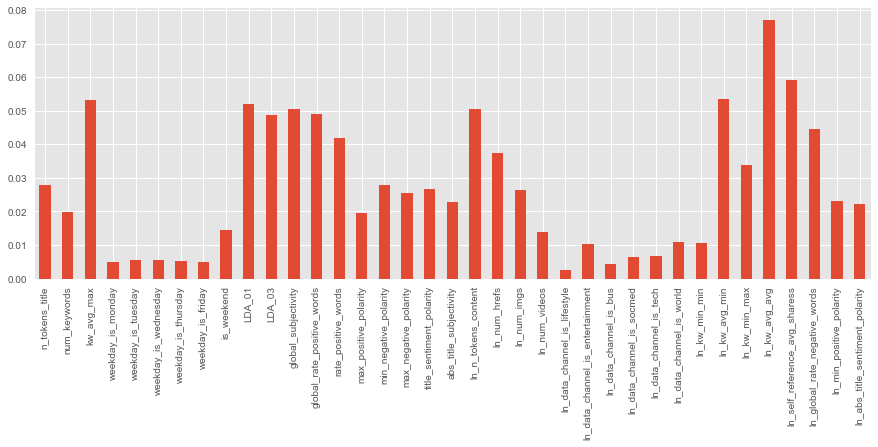

In [96]:
%matplotlib inline
rcParams['figure.figsize'] = 15, 5
plt.style.use('ggplot')

weights = pd.Series(abs(RFclf.feature_importances_), index = df_pop.columns)
weights.plot(kind = 'bar')
plt.show()

In the random forest model, the importance of the variables are not the same as they were in the logistic regression model examined earlier ubt very similar to the decision tree model. The amount of key words is most important, next are self reference average shares. This result is interesting and maybe not intuitive, but variables such as the weekend indicator and variables related to the actual sharing process such as keywords show up here.

##  d: Naive Bayes


#### d.1 Multinomial Naive Bayes

In [47]:
from sklearn.naive_bayes import MultinomialNB

MNBclf = MultinomialNB(
    alpha = 0.01,
    class_prior = None,
    fit_prior = True)

params = {
    'alpha':[0.1, 0.5, 1.0]
}

MNB_grid_search = GridSearchCV(
    MNBclf,
    params,
    cv = 3)

grid_search = MNB_grid_search.fit(master_X_train, master_y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

best_accuracy
best_parameters

best_alpha = best_parameters['alpha']

0.61809869147091279

{'alpha': 0.1}

In [48]:
tic = time.clock()

# train and test 

MNBclf = MultinomialNB(
    alpha = best_alpha,
    class_prior = None,
    fit_prior = True)

MNBclf.fit(X_train, y_train)
y_predMNB = MNBclf.predict(X_test)

# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(y_test, y_predMNB))
precision = '{0:.4f}'.format(metrics.precision_score(y_test, y_predMNB, average ='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(y_test, y_predMNB, average = 'weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(y_test, y_predMNB, average = 'weighted'))
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)

# print statistics
print("accuracy",accuracy )
print("precision",precision )
print("recall",recall )
print("f1_score",f1_score )
print("confusion matrix\n", confusion_matrix(y_test, y_predMNB))
print('process time',exetime)
print("\n")


# save statistics for model comparison

raw_data = {
    'Model Name':'Multinomial Naïve Bayes',
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'FScore':f1_score,
    'Processing Time': exetime
}

df_tbl = pd.DataFrame(raw_data,
        columns = ['Model Name','Accuracy','Precision','Recall','FScore','Processing Time'],
        index = [i_index + 1])

comparison_tbl = comparison_tbl.append(df_tbl)

#append model classifier for cross-validation

models.append(('Multinomial Naïve Bayes', MNBclf))


MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

accuracy 0.6199
precision 0.6197
recall 0.6199
f1_score 0.6195
confusion matrix
 [[2122 1132]
 [1279 1810]]
process time 0.0423




#### d.2 Gaussian Naive Bayes

In [49]:
from sklearn.naive_bayes import GaussianNB

tic = time.clock()

# train and test 

GNBclf = GaussianNB()

GNBclf.fit(X_train, y_train)
y_predGNB = GNBclf.predict(X_test)

# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(y_test, y_predGNB))
precision = '{0:.4f}'.format(metrics.precision_score(y_test, y_predGNB, average ='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(y_test, y_predGNB, average = 'weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(y_test, y_predGNB, average = 'weighted'))
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)

# print statistics
print("accuracy",accuracy )
print("precision",precision )
print("recall",recall )
print("f1_score",f1_score )
print("confusion matrix\n", confusion_matrix(y_test, y_predGNB))
print('process time',exetime)
print("\n")


# save statistics for model comparison

raw_data = {
    'Model Name':'Gaussian Naïve Bayes',
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'FScore':f1_score,
    'Processing Time': exetime
}

df_tbl = pd.DataFrame(raw_data,
        columns = ['Model Name','Accuracy','Precision','Recall','FScore','Processing Time'],
        index = [i_index + 1])

comparison_tbl = comparison_tbl.append(df_tbl)

#append model classifier for cross-validation

models.append(('Gaussian Naïve Bayes', GNBclf))

GaussianNB(priors=None)

accuracy 0.6194
precision 0.6193
recall 0.6194
f1_score 0.6188
confusion matrix
 [[2140 1114]
 [1300 1789]]
process time 0.0429




#	Modeling and Evaluation 4

### Evaluation metrics

In [50]:
# converting acc, pre, recall, fscore and time to numeric values for plots

comparison_tbl = comparison_tbl.reset_index(drop=True)
comparison_tbl['Precision'] = pd.to_numeric(comparison_tbl['Precision'])
comparison_tbl['Accuracy'] = pd.to_numeric(comparison_tbl['Accuracy'])
comparison_tbl['FScore']= pd.to_numeric(comparison_tbl['FScore'])
comparison_tbl['Processing Time'] = pd.to_numeric(comparison_tbl['Processing Time'])
comparison_tbl['Recall'] = pd.to_numeric(comparison_tbl['Recall'])
comparison_tbl


,Model Name,Accuracy,Precision,Recall,FScore,Processing Time
0,Logistic Regression,0.6342,0.6348,0.6342,0.6343,0.9443
1,Decision Tree Classifier,0.6346,0.6353,0.6346,0.6327,0.4662
2,Random Forest Classifier,0.6606,0.6606,0.6606,0.6606,109.3763
3,Multinomial Naïve Bayes,0.6199,0.6197,0.6199,0.6195,0.0423
4,Gaussian Naïve Bayes,0.6194,0.6193,0.6194,0.6188,0.0429


#### Visualization of metrics

[None, None, None, None, None, None, None, None, None, None, None, None]

[None, None, None, None, None, None, None, None, None, None, None, None]

TypeError: unsupported operand type(s) for /: 'str' and 'int'

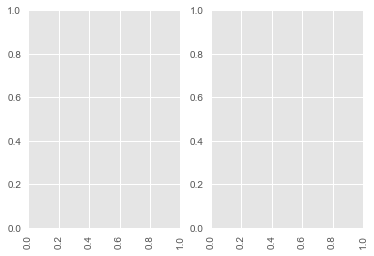

In [105]:
from pylab import rcParams
%matplotlib inline

fig, axs = plt.subplots(ncols = 2)
plt.setp(axs[0].xaxis.get_majorticklabels(), rotation = 90 )
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation = 90 )
sns.barplot(x = 'Model Name', y = 'Accuracy', data = comparison_tbl, ax = axs[0])
sns.barplot(data = comparison_tbl, y = 'Processing Time', x = 'Model Name', ax = axs[1])


# 10-K Cross-Validation for each classifier
For each classifier we run 10 fold cross validation which will help us narrow down one final model

In [52]:
from sklearn import model_selection

# evaluate each model in turn

results = []
names = []
scoring = 'accuracy'

for name, model in models:
    cv_results = model_selection.cross_val_score(
        model,
        master_X_train,
        master_y_train,
        cv = 10,
        scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "\n\t%-35s mean (std dev): %.3f (%.4f)" % (name, cv_results.mean(), cv_results.std())
    #print(cv_results)
    print(msg)

[ 0.62937283  0.63031831  0.62862547  0.62377799  0.62850836  0.63481552
  0.62850836  0.62472406  0.63670766  0.63355408]

	Logistic Regression                : 0.630 (0.0039)


[ 0.64418531  0.63662149  0.63650694  0.62630085  0.6439609   0.64206875
  0.63450016  0.62503942  0.63923053  0.6341848 ]

	Decision Tree Classifier           : 0.636 (0.0063)


[ 0.671289    0.66813741  0.6557377   0.66099022  0.67076632  0.66855881
  0.67455061  0.65279092  0.67549669  0.65689057]

	Random Forest Classifier           : 0.666 (0.0078)


[ 0.61771194  0.6281122   0.61065574  0.61463261  0.6222012   0.62535478
  0.61494797  0.59571113  0.6222012   0.62377799]

	Multinomial Naïve Bayes            : 0.618 (0.0089)


[ 0.62023322  0.63283958  0.61790668  0.62945443  0.61873226  0.62093977
  0.6124251   0.60832545  0.63639231  0.62062441]

	Gaussian Naïve Bayes               : 0.622 (0.0083)




{'boxes': [<matplotlib.lines.Line2D at 0x7f75ec1a4e48>,
 'caps': [<matplotlib.lines.Line2D at 0x7f75ec0d5b38>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f75ed92ffd0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f75ec0dbc18>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f75ec1e19b0>,
  <matplotlib.lines.Line2D at 0x7f75ec242a20>]}

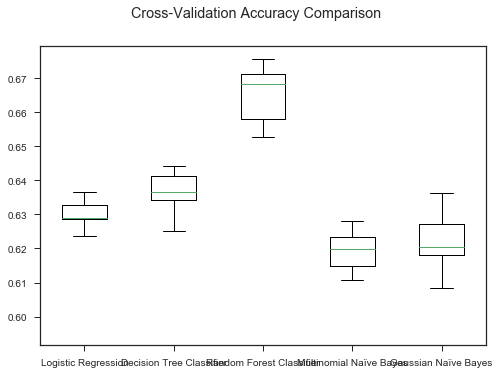

In [53]:
# boxplot accuracy comparison

fig = plt.figure()
fig.suptitle('Cross-Validation Accuracy Comparison')
ax = fig.add_subplot(111)

plt.boxplot(results)

ax.set_xticklabels(names, rotation=90)
plt.show()


## Holdout test data set prediction with our final model

Our final best model is Random Forest Classifier. We will run prediction on that fit with the test data set we set aside at the beggining of the project. We will calculate statistics for the prediction.

In [54]:
y_predFinal = RFclf.predict(golden_X_test)

# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(golden_y_test, y_predFinal))
precision = '{0:.4f}'.format(metrics.precision_score(golden_y_test, y_predFinal, average ='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(golden_y_test, y_predFinal, average = 'weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(golden_y_test, y_predFinal, average = 'weighted'))
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)

# print statistics
print("accuracy", accuracy )
print("precision", precision )
print("recall", recall )
print("f1_score", f1_score )
print("confusion matrix\n", confusion_matrix(y_test, y_predRF))
print('process time', exetime)
print("\n")


accuracy 0.6588
precision 0.6588
recall 0.6588
f1_score 0.6588
confusion matrix
 [[2170 1084]
 [1069 2020]]
process time 1259.3225




  
<hr size = "5">  

# Task 02 - Second Classifier  

<hr size = "5">  


### __To the reader__  :  

This next section is data preparation associated to the Task 2 - classifier for assigning an article to a data_channel.
The method is very similar to what was employed for the Task 1, but the steps here need to be repeated since the data columns retained are different between the 2 classification tasks.  

The next several sections are similar in structure and content to what was shown above, but here the data reduction and cleaning is now done specifically for the 2nd classification task.  

To avoid reviewing the repetitive nature of this section, feel free to skip to the section beginning with __Modeling & Evaluation 2__ - which begins the work that is dedicated to developing this 2nd classification model.  









### __Data Prep 01__  

Similar methods and processes as constructed for Task 1, with differences related to different data set content specific to Task 2 classification model.

### __Data Prep 02__  

Similar methods and processes as constructed for Task 1, with differences related to different data set content specific to Task 2 classification model.

### __Modeling and Evaluation 01__   

Choose and explain the evaluation metrics that we will use. Why are the measures appropriate for analyzing the results of this model ? Give a detailed explanation backing up any assertions.

We intend to mine this data to understand what parameters can influence an article to be shared on social media more than others.  The goal in _Task 1_ is to predict the number of shares in social networks (popularity).  

The business use of this data set / data mining project is ultimately to establish relationships that enable to predict how many social media shares an article published on _www.mashable.com_ is likley to generate - with the idea that a more socially shared article has higher business value - increasing traffic to the site, and consequently, potential for higher earnings revenue associated to the increased web traffic. The user of this model is both the publishers for _mashable.com_ for article selection, and also for authors, attempting to create content that has higher value on sites like _mashable.com_.  

Measures for a successful outcome from a predictive model for this study will be based on overall accuracy metrics (e.g., confusion matrix), as well as AUC type metrics. A baseline (non-predictive, random) scoring will establish a baseline for these metrics, and then the predictive model can be assessed against a random model for measurement of improvement, i.e., value of the model.  

For this business case, we consider 2 risks :  
 - 1 - there is an article that has high potential for high popularity and our model classifies this incorrectly as not popular  
 - 2 - there are articles that are not likely to be popular, and our model incorrectly classifies the article as high potential for high popularity  
  
  In the first case, our model is missing opportunity to identify a highly valuable asset, whereas in the second case our model highly values that which has no value. For our business case, the distinction between popular and not_popular was established at the median value for number of shares of each article. In this case, then, there are, by this measure, an equal number of popular and not_popular articles. 

***  

#### Import required packages  

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter('ignore',DeprecationWarning)
import seaborn as sns
import time
#import hdbscan

from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

#from sklearn.datasets import make_blobs

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn import metrics as mt
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix as conf
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

from tabulate import tabulate

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### Read in dataset from .csv file  

In [ ]:
data_dir = '../data/'
data_file = 'OnlineNewsPopularity.csv'

file_2_read = data_dir + data_file
df = pd.read_csv(file_2_read)  

In [57]:
df.columns = df.columns.str.strip()
col_names = df.columns.values.tolist()

# Data Preparation Part 1	

Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.

### Task 2 data set definition  

 - For Task 2 classification we will classify the articles according to which data channel they are most likely to belong. The business case for this is to support directing the article to the data_channel most appropriate for the article content.  
 - In order to support this classification task, we create a new dependent variable column __data_channel__  which combines all of the individual binary boolean columns of __data_channel_is_xxx__ to __data_channel__ column with appropriate value  
 - We create 2 sets of this dependent variable, __data_channel__ and __data_channel_n__ . The only difference between these 2 columns is that __data_channel__ contains the text values for data channel category while the __data_channel_n__ contains an integer classifier (1 --> 7) which we associate to the text description in alphabetic order.  We create 2 versions of the column to be able to use the text version, when feasible, and the integer version in the case that that is required for a particular classifier routine.  
 - There are approx 15% of the articles which contain no identified __data_channel__ in the original data set. We create a new category, _Others_, for the articles without assignation to one of the standard data channels.  

In [58]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... creating data_channel categorical variable
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df['data_channel'] = 'Others'

condition = df['data_channel_is_lifestyle'] == 1
df.loc[condition, 'data_channel'] = 'Lifestyle'

condition = df['data_channel_is_entertainment'] == 1
df.loc[condition, 'data_channel'] = 'Entertainment'

condition = df['data_channel_is_bus'] == 1
df.loc[condition, 'data_channel'] = 'Business'

condition = df['data_channel_is_socmed'] == 1
df.loc[condition, 'data_channel'] = 'Social Media'

condition = df['data_channel_is_tech'] == 1
df.loc[condition, 'data_channel'] = 'Technology'

condition = df['data_channel_is_world'] == 1
df.loc[condition, 'data_channel'] = 'World'

del df['data_channel_is_lifestyle']
del df['data_channel_is_entertainment']
del df['data_channel_is_bus']
del df['data_channel_is_socmed']
del df['data_channel_is_tech']
del df['data_channel_is_world']


In [59]:
df.data_channel.value_counts()

World            8427
Technology       7346
Entertainment    7057
Business         6258
Others           6134
Social Media     2323
Lifestyle        2099
Name: data_channel, dtype: int64

In [60]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... integer value of categorical values for multinomial NB classification
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df['data_channel_n'] = 0

condition = df['data_channel'] == 'Business'
df.loc[condition, 'data_channel_n'] = 1

condition = df['data_channel'] == 'Entertainment'
df.loc[condition, 'data_channel_n'] = 2

condition = df['data_channel'] == 'Lifestyle'
df.loc[condition, 'data_channel_n'] = 3

condition = df['data_channel'] == 'Others'
df.loc[condition, 'data_channel_n'] = 4

condition = df['data_channel'] == 'Social Media'
df.loc[condition, 'data_channel_n'] = 5

condition = df['data_channel'] == 'Technology'
df.loc[condition, 'data_channel_n'] = 6

condition = df['data_channel'] == 'World'
df.loc[condition, 'data_channel_n'] = 7



### Remove variables that are not useful  


#### Delete __shares__ from the Task 2 data set 

__shares__ is the Task 1 dependent variable

we are excluding it from the Task 2 dataset as per the business model this value is not available during data_channel selection

The business model being developed here is that an article is proposed for publication, a set of text processing routines will extract and develop the model features from the raw article. The next step is to deploy the __data_channel__ assignment (classification) model, which is then also a necessary ingredient for the final model, Task 1, which is to estimate the __popularity__ of the article and thus provide recommendation to publish or not to publish.

Thus, for this Task 2 data set, we exclude the __shares__ data value.


In [62]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  shares is task 1 dependent variable
# ...  we are excluding it from this model as per business model this value is not available
# ...  during data_channel prediction
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

del df['shares'] 


In [63]:
del df['n_non_stop_words']
del df['n_non_stop_unique_tokens']
del df['n_unique_tokens']
del df['url']

In [64]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
timedelta,39644.0,354.530471,214.163767,8.00000,164.000000,339.000000,542.000000,731.000000
n_tokens_title,39644.0,10.398749,2.114037,2.00000,9.000000,10.000000,12.000000,23.000000
n_tokens_content,39644.0,546.514731,471.107508,0.00000,246.000000,409.000000,716.000000,8474.000000
num_hrefs,39644.0,10.883690,11.332017,0.00000,4.000000,8.000000,14.000000,304.000000
num_self_hrefs,39644.0,3.293638,3.855141,0.00000,1.000000,3.000000,4.000000,116.000000
num_imgs,39644.0,4.544143,8.309434,0.00000,1.000000,1.000000,4.000000,128.000000
num_videos,39644.0,1.249874,4.107855,0.00000,0.000000,0.000000,1.000000,91.000000
average_token_length,39644.0,4.548239,0.844406,0.00000,4.478404,4.664082,4.854839,8.041534
num_keywords,39644.0,7.223767,1.909130,1.00000,6.000000,7.000000,9.000000,10.000000
kw_min_min,39644.0,26.106801,69.633215,-1.00000,-1.000000,-1.000000,4.000000,377.000000


#### Assign certain variables to type integer, as appropriate

In [65]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  convert the data type to Integer
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

to_int = ['timedelta','n_tokens_title', 'n_tokens_content',
    'num_hrefs','num_self_hrefs', 'num_imgs', 'num_videos', 'num_keywords',
    'weekday_is_monday',
    'weekday_is_tuesday',
    'weekday_is_wednesday',
    'weekday_is_thursday',
    'weekday_is_friday',
    'weekday_is_saturday',
    'weekday_is_sunday',
    'is_weekend',
    'data_channel_n']
    

df[to_int] = df[to_int ].astype(np.int64)

In [66]:
df[df.duplicated()]

,timedelta,n_tokens_title,n_tokens_content,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,kw_min_min,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,data_channel,data_channel_n


#### Impute kw_avg_max for 0-values and re-scale to standard normal scale

 - A small number of rows have 0 value for __kw_avg_max__, which is completely out of range for the remaining rows of this variable.    
 - We will impute these rows to median value of the column  
 
 - The magnitude of this column of data is markedly different than the range of values in the remaining columns in the data set. To bring this back in line, we will re-scale the values in this column to standard normal range

In [67]:

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  impute to median value for a few rows of kw_avg_max
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

condition = df['kw_avg_max'] == 0
df.loc[condition, 'kw_avg_max'] = df.kw_avg_max.median()


# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  scale to standard normal scale
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df.kw_avg_max = (df.kw_avg_max - df.kw_avg_max.mean()) / df.kw_avg_max.std()


244572.22222250002

244575.00000025

#### Constant offset for variables with min value < 0  

 - This allows to consider these variables for ln() transform if highly right-skewed and also supports some classification models that only accept independent variables that are > 0  
 - Method here is to just add -1 * min_value of any column for which min_value < 0

In [68]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  for all columns with negative values, add +1 to all values in the column
# ...  - the only columns with negative values are polarity / sentiment measures
# ...  - adding a constant to all values does not modify distributions
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_numeric = df.select_dtypes(['number'])
numeric_col_names = df_numeric.columns.values.tolist()

# ... store min value for each column

df_mins = df.min()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  loop on each column, test for min < 0, add constant as applicable
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

for column in numeric_col_names :
    if df_mins[column] < 0 :
        df[column] = df[column] - df_mins[column]
        
#        print('--> min_value < 0 adjusted : ', column, df_mins[column])

#### Ln() transform for variables that are right skewed (skewness > 1)  

 - This facilitiates maintaining more normally distributed residuals for regression models  
 - Likely, this will not be needed for the classification task, at present, but also does not have negative effects for this current activity


In [69]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  ln() transform right skewed distribution variables (skewness > 1)
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_numeric = df.select_dtypes(['number'])

numeric_col_names = df_numeric.columns.values.tolist()

# ... store min value for each column

df_mins = df.min()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  loop on each column, test for skewness, create new column if conditions met
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

columns_to_drop = []

for column in numeric_col_names:
    sk = df[column].skew()
    
    if(sk > 1):
        new_col_name = 'ln_' + column
        print (column, sk, new_col_name)
        
        if df_mins[column] > 0:
            df[new_col_name] = np.log(df[column])
            columns_to_drop.append(column)
            
        elif df_mins[column] == 0:
            df_tmp = df[column] + 1
            df[new_col_name] = np.log(df_tmp)
            columns_to_drop.append(column)
            
        else:
            print('--> Ln() transform not completed -- skew > 1, but min value < 0 :', column, '!!')
            
            
# ... delete tmp data

del df_tmp
del df_mins
del df_numeric

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  based on inspection, a few of these are just not valid ranges in ln() space
# ...  -- just delete these few back out of the data set
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

print (columns_to_drop)

del df['ln_LDA_00']
del df['ln_LDA_01']
del df['ln_LDA_02']
del df['ln_LDA_03']
del df['ln_LDA_04']
columns_to_drop.remove('LDA_00')
columns_to_drop.remove('LDA_01')
columns_to_drop.remove('LDA_02')
columns_to_drop.remove('LDA_03')
columns_to_drop.remove('LDA_04')

# ...  these are binary indicators ... so no need to ln-transform

del df['ln_weekday_is_monday']
del df['ln_weekday_is_tuesday']
del df['ln_weekday_is_wednesday']
del df['ln_weekday_is_thursday']
del df['ln_weekday_is_friday']
del df['ln_weekday_is_saturday']
del df['ln_weekday_is_sunday']
del df['ln_is_weekend']
columns_to_drop.remove('is_weekend')
columns_to_drop.remove('weekday_is_monday')
columns_to_drop.remove('weekday_is_tuesday')
columns_to_drop.remove('weekday_is_wednesday')
columns_to_drop.remove('weekday_is_thursday')
columns_to_drop.remove('weekday_is_friday')
columns_to_drop.remove('weekday_is_saturday')
columns_to_drop.remove('weekday_is_sunday')

#columns_to_drop.remove('data_channel')

print ('\n-----------------------------------\n')
print ('Number of current columns in dataset :', len(df.columns))

df.drop(columns_to_drop, axis = 1, inplace = True)

#df.info()


n_tokens_content 2.94542193879 ln_n_tokens_content
num_hrefs 4.0134948282 ln_num_hrefs
num_self_hrefs 5.17275110576 ln_num_self_hrefs
num_imgs 3.94659584465 ln_num_imgs
num_videos 7.0195327863 ln_num_videos
kw_min_min 2.37494728018 ln_kw_min_min
kw_max_min 35.3284337312 ln_kw_max_min
kw_avg_min 31.3061081027 ln_kw_avg_min
kw_min_max 10.3863716348 ln_kw_min_max
kw_max_avg 16.4116695554 ln_kw_max_avg
kw_avg_avg 5.76017729162 ln_kw_avg_avg
self_reference_min_shares 26.2643641603 ln_self_reference_min_shares
self_reference_max_shares 13.8708490494 ln_self_reference_max_shares
self_reference_avg_sharess 17.9140933777 ln_self_reference_avg_sharess
weekday_is_monday 1.77590824423 ln_weekday_is_monday
weekday_is_tuesday 1.61054706191 ln_weekday_is_tuesday
weekday_is_wednesday 1.60097097689 ln_weekday_is_wednesday
weekday_is_thursday 1.6370700483 ln_weekday_is_thursday
weekday_is_friday 2.03030483518 ln_weekday_is_friday
weekday_is_saturday 3.63708575997 ln_weekday_is_saturday
weekday_is_sunday

# Data Preparation Part 2

#### Data Selection - Task 2 - data_channel classification

- There are 60 columns in the original data set; we added a few additonal columns based on observed opportunities (e.g., _publication_date_, ...) as explained above. 
    
- From this data set, we did a simple correlation matrix to look for variables that are highly correlated with each other that could be removed with little loss of information.

- With that downselection, we proceeded with additional evaluation of these remaining variables.
    
- we recognize that there is likely significant additional opportunity for modeling improvements with many of the remaining variables, and will look to re-expand the data set to further consider that with future work.  

In [70]:

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... display highest correlation pairs from corr() matrix 
# ...
# ... https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_numeric = df.select_dtypes(['number'])

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n = 5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels = labels_to_drop).sort_values(ascending = False)
    return au_corr[0:n]

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... list out Top30 correlations
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

n_val = 30

top_30_corr_list = get_top_abs_correlations(df_numeric, n_val)
print("\n\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
print("Top Absolute Correlations\n")
print(top_30_corr_list)


icor = 0
drop_column = list()
while (top_30_corr_list[icor] > 0.65):
    drop_column.append(top_30_corr_list[top_30_corr_list == top_30_corr_list[icor]].index[0][0])
    icor += 1

drop_column = list(set(drop_column))

print("\n\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
print("Columns Recommended for removal based on correlation > 0.65")
print("-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-\n")

print("\n".join(sorted(drop_column)))

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... drop one of the high correlation columns (2nd of the pair)
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df = df.drop(drop_column, axis = 1)

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... show correlation test with remaining, to confirm
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

df_reduced_numeric = df.select_dtypes(['number'])

top_30_corr_list = get_top_abs_correlations(df_reduced_numeric, n_val)

print("\n\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
print("\n\nTop Absolute Correlations (2nd Pass)\n")
print(top_30_corr_list)




-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Top Absolute Correlations

ln_self_reference_max_shares  ln_self_reference_avg_sharess      0.994639
ln_self_reference_min_shares  ln_self_reference_avg_sharess      0.971014
ln_kw_max_min                 ln_kw_avg_min                      0.946087
ln_self_reference_min_shares  ln_self_reference_max_shares       0.945943
kw_min_avg                    ln_kw_min_max                      0.926784
ln_kw_max_avg                 ln_kw_avg_avg                      0.899409
timedelta                     ln_kw_min_min                      0.822783
kw_max_max                    ln_kw_min_min                      0.820625
rate_negative_words           ln_global_rate_negative_words      0.782517
average_token_length          ln_n_tokens_content                0.768795
avg_negative_polarity         min_negative_polarity              0.748896
title_subjectivity            ln_abs_title_sentiment_polarity    0.741229
global_sentiment_polarity

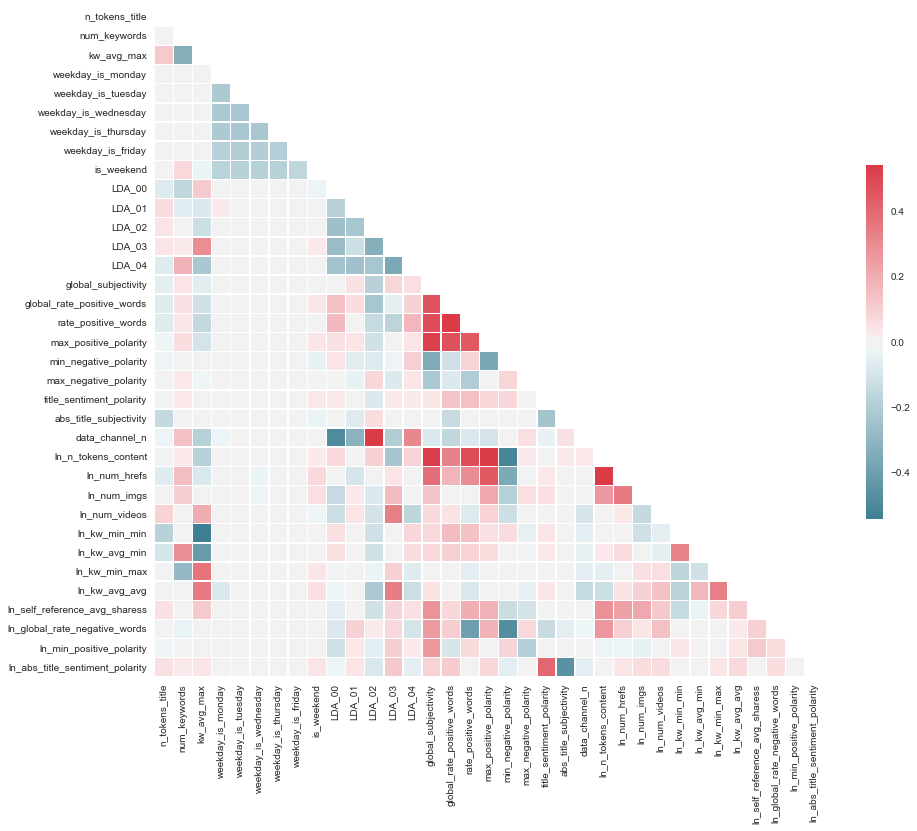

In [71]:
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 13))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


# from example found at https://www.kaggle.com/maheshdadhich/strength-of-visualization-python-visuals-tutorial/notebook

#### Save cleaned / reduced data set to external .csv file  

 - This provides opportunity to just read in this .csv file and no need to repeat data cleaning / reduction process for each execution  
 

In [72]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... store in ../data/ directory
# ... write as .csv file for future recall
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

data_dir = '../data/'
data_file = 'mashable_clean_dataset_for_lab_02_task_02.csv'

file_2_write = data_dir + data_file

df.to_csv(file_2_write, index = False)


# 	Modeling and Evaluation 2

### Holdout, Training and Test split

In [73]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  copy data frame to classification working data frame
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

# ... data set with text categorical target values 

df_data_channel = df.copy()
del df_data_channel['data_channel_n']

# ... data set with integer categorical target values 

df_data_channel_n = df.copy()
del df_data_channel_n['data_channel']

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  separate X and y matrices 
# ...
# ...  convert to numpy matrices by calling 'values' on the pandas data frames
# ...  they are now simple matrices for compatibility with scikit-learn
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

if 'data_channel' in df_data_channel:
    y = df_data_channel['data_channel'].values         # set 'data_channel' as dependent
    del df_data_channel['data_channel']                # remove from dataset
    X = df_data_channel.values                         # use everything else for independent EVs

if 'data_channel_n' in df_data_channel_n:
    y_n = df_data_channel_n['data_channel_n'].values    # set 'data_channel' as dependent
    del df_data_channel_n['data_channel_n']             # remove from dataset
    X_n = df_data_channel_n.values                      # use everything else for independent EVs

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ...  setup master train and test , golden traina and test
# ...  master sets - first 80% of original data set which will be base training for model building
# ...  Golden sets - 20% of original will be used in the final best model for prediction
# ...  split into training and test sets
# ....  --> 10 folds
# ...   --> 80% / 20% training / test
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=




In [74]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... Set-up golden test data set
# ... This data-set will be used to evaluate the predictive capability of the final
# ... model on a data set that was not included in any of the prior train/test sets
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

num_cv_iterations = 1
cv_object = ShuffleSplit(n_splits = num_cv_iterations,
                         test_size  = 0.2)
                        
print(cv_object)

for train_indices, test_indices in cv_object.split(X, y):
    master_X_train = X[train_indices]
    master_y_train = y[train_indices]    
    golden_X_test  = X[test_indices]
    golden_y_test  = y[test_indices]
    print(master_X_train.shape)

for train_indices_n, test_indices_n in cv_object.split(X_n, y_n): 
    master_X_train_n = X_n[train_indices_n]
    master_y_train_n = y_n[train_indices_n]    
    golden_X_test_n  = X_n[test_indices_n]
    golden_y_test_n  = y_n[test_indices_n]
    
    
    

ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=None)
(31715, 34)


In [75]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... Set-up training set to be used on 'best' model from grid search results
# ... This data-set will be used to verify 10-fold-CV-model has results consistent
# ... with the model produced from grid search
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

num_cv_iterations = 1
cv_object = ShuffleSplit(n_splits = num_cv_iterations,
                         test_size  = 0.2)
                        
print(cv_object)

for train_indices, test_indices in cv_object.split(master_X_train, master_y_train):
    X_train = master_X_train[train_indices]
    y_train = master_y_train[train_indices]    
    X_test  = master_X_train[test_indices]
    y_test  = master_y_train[test_indices]
    print(X_train.shape)

for train_indices_n, test_indices_n in cv_object.split(master_X_train_n, master_y_train_n): 
    X_train_n = master_X_train_n[train_indices_n]
    y_train_n = master_y_train_n[train_indices_n]    
    X_test_n  = master_X_train_n[test_indices_n]
    y_test_n  = master_y_train_n[test_indices_n]


ShuffleSplit(n_splits=1, random_state=None, test_size=0.2, train_size=None)
(25372, 34)


In [76]:
# set required variables for model comparison

comparison_tbl = pd.DataFrame(columns = [
    'Model Name',
    'Accuracy',
    'Precision',
    'Recall',
    'FScore',
    'Processing Time'])

i_index=[]
i_index = 0

# preparation for cross validation and model comparison, each classifier is appended once model is fit

models = []

# 	Modeling and Evaluation 3	

For task 2 we have chosen the following 4 models:<br>
a. Multinomial logistic regression with parament selection using Grid Search<br>
b. Decision Tree with parament selection using Grid Search<br>
c. Random Forest with parament selection using Grid Search<br>
d. Naive Bayes<br>

Each of these models will be evaluated on Accuracy, Precision, Recall, FScore and Execution time

### a. Multinomial logistic regression
For multinomial LR we have set standard attributes with:
    class_weight = balanced<br>
    multi_class = multinomial<br>
<b>search params:</b><br>
    tolerance parament tol<br>
    Regularization parament C<br>
    
    
#### _Grid selection for logistic regression_

In [77]:
from sklearn.grid_search import GridSearchCV

lr_model = LogisticRegression(
    class_weight = 'balanced',
    multi_class = 'multinomial',
    solver = 'lbfgs',
    C = 10,
    tol = 0.1)

params = {
    'C':[100, 1000], 
    'tol': [0.001, 0.0001]
}

# ... --> changed the scoring on Sat 28-Oct
# ...     - from : log_loss
# ...     - to : neg_log_loss
# ...  (this avoids the deprecation warning)

clf = GridSearchCV(
    lr_model,
    params,
    scoring = 'neg_log_loss',
    refit = 'True',
    n_jobs = -1,
    cv = 3)

grid_search = clf.fit(master_X_train, master_y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
best_C = best_parameters['C']
best_tol = best_parameters['tol']

#### _Best parameter values for logistic regression_:

In [78]:
best_accuracy
best_parameters

-0.7512033918501767

{'C': 1000, 'tol': 0.001}

#### Create main logistic model using best paraments for further analysis and model comparisons

In [80]:
tic = time.clock()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... basic multiclass Logistic Regression
# ... - normalize features based on mean & stdev of each column
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

lr_model1 = LogisticRegression(
    class_weight = 'balanced',
    multi_class = 'multinomial',
    solver = 'lbfgs',
    C = best_C,
    tol = best_tol)

lr_model1.fit(X_train, y_train)  # train object

y_hat = lr_model1.predict(X_test) # get test set precitions

toc =  time.clock()

# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(y_test, y_hat))
precision = '{0:.4f}'.format(metrics.precision_score(y_test, y_hat,average='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(y_test, y_hat,average='weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(y_test, y_hat,average='weighted'))

exetime = '{0:.4f}'.format(toc-tic)

# print statistics

print("accuracy",accuracy )
print("precision",precision )
print("recall",recall )
print("f1_score",f1_score )
print("confusion matrix\n", conf(y_test, y_hat))
print('process time',exetime)
print("\n")

lr_model1_confusion_matrix = conf(y_test, y_hat)

# save statistics for model comparison

raw_data = {
    'Model Name' : 'Logistic Regression',
    'Accuracy' : accuracy,
    'Precision' : precision,
    'Recall' : recall,
    'FScore' : f1_score,
    'Processing Time' : exetime
}

df_tbl = pd.DataFrame(raw_data,
    columns = ['Model Name', 'Accuracy', 'Precision', 'Recall', 'FScore', 'Processing Time'],
    index = [i_index + 1])

comparison_tbl = comparison_tbl.append(df_tbl)

#append model classifier for cross-validation

models.append(('Logistic Regression', lr_model1))


LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.001, verbose=0,
          warm_start=False)

accuracy 0.7197
precision 0.7513
recall 0.7197
f1_score 0.7315
confusion matrix
 [[ 750   14   18    9  136   38   12]
 [   4  810   31  190   51    7   32]
 [  18   10  151   23   25   86   11]
 [   9  154   20  832   21    1    8]
 [  73   22   36   28  182   14   36]
 [  27    8  293    2   21  724   61]
 [   9   20   47   32   60   61 1116]]
process time 4.7239




### Heatmap of co-efficients from logistic regression viewed by data_channels

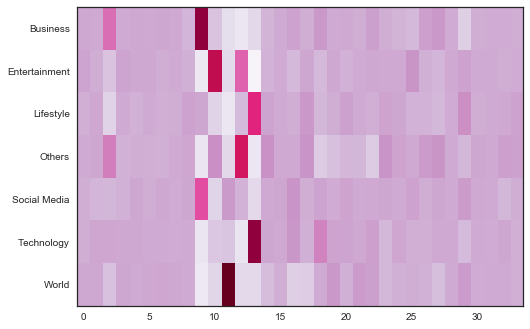

In [82]:
channels_list = sorted(df['data_channel'].unique())
channels_list.insert(0,0)
features_list = df_data_channel.columns.values.tolist()

fig, ax = plt.subplots()

plt.imshow(lr_model1.coef_, cmap = plt.get_cmap('PuRd'), aspect = 'auto')

ax.set_yticklabels(channels_list)
#ax.set_xticklabels(features_list, rotation = 'vertical')

plt.grid(False)

*********** TODO*********** add interpretation of above plot

#### Heatmap of confusion matrix from logistic regression

For multiclass models, confusion matrix is better visualizied as heat map

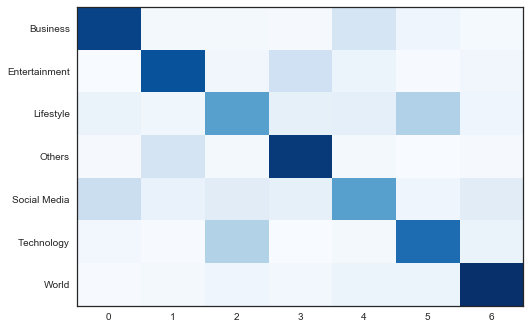

In [84]:
lr_model1_confusion_matrix = conf(y_test, y_hat)

cm_normalized = lr_model1_confusion_matrix.astype('float') / lr_model1_confusion_matrix.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()

plt.imshow(cm_normalized, cmap = plt.get_cmap('Blues'), aspect = 'auto')

ax.set_yticklabels(channels_list)
ax.set_xticklabels(channels_list, rotation = "vertical")

plt.grid(False)

# Interpret weights

In [85]:
zip_vars_LR = zip(lr_model1.coef_.T, df_data_channel.columns.values.tolist()) # combine attributes

print(zip_vars_LR)
for importance, name in zip_vars_LR:
    print('\t%-35s - weight = %9.3f' % ( name, importance) # now print them out

************ TODO write interpretation of weights****

### b. Decision Tree Classifier using Grid Search
#### _Grid search parameter set-up_

In [88]:
# Applying Grid Search to find the best model and the best parameters

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

DTclassifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)

parameters = [
      {
        'criterion': ['gini'], 
        'max_depth': [None], 
        'min_samples_split': [2, 100, 1000], 
        'min_samples_leaf': [1, 10, 100],
        'max_features': [None], 'max_leaf_nodes': [None]
      },
      {
          'criterion': ['entropy'], 
          'max_depth': [None, 5, 10], 
          'min_samples_split': [2, 100, 1000],
          'min_samples_leaf': [1, 10, 100], 
          'max_leaf_nodes': [None]
      }
     ]

grid_search = GridSearchCV(estimator = DTclassifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 3,
                           n_jobs = -1)

grid_search = grid_search.fit(master_X_train, master_y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

best_criterion = best_parameters['criterion']
best_max_depth = best_parameters['max_depth']
best_max_leaf_nodes = best_parameters['max_leaf_nodes']
best_min_samples_split = best_parameters['min_samples_split']
best_min_samples_leaf = best_parameters['min_samples_leaf']
best_max_features = best_parameters['max_features']


#### _Best parameters for Decision Tree_

In [89]:
best_accuracy
best_parameters

0.76320353145199438

{'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 10,
 'min_samples_split': 100}

#### _use best parameters to create best Decision Tree model for further analysis and model comparison_

In [90]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,classification_report

tic = time.clock()

# train and fit

DTclassifier = DecisionTreeClassifier(
    criterion = best_criterion,
    max_depth = best_max_depth,
    min_samples_split = best_min_samples_split,
    min_samples_leaf = best_min_samples_leaf,
    max_features = best_max_features,
    max_leaf_nodes = best_max_leaf_nodes)

DTclassifier.fit(X_train, y_train)
y_predDT = DTclassifier.predict(X_test)

# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(y_test, y_predDT))
precision = '{0:.4f}'.format(metrics.precision_score(y_test, y_predDT,average='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(y_test, y_predDT,average='weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(y_test, y_predDT,average='weighted'))
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)

# print statistics
print("accuracy",accuracy )
print("precision",precision )
print("recall",recall )
print("f1_score",f1_score )
print("confusion matrix\n", confusion_matrix(y_test, y_predDT))
print('process time',exetime)
print("\n")

# save statistics for model comparison

raw_data = {
    'Model Name':'Decision Tree Classifier',
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'FScore':f1_score,
    'Processing Time': exetime
}

df_tbl = pd.DataFrame(raw_data,
        columns = ['Model Name','Accuracy','Precision','Recall','FScore','Processing Time'],
        index = [i_index + 1])

comparison_tbl = comparison_tbl.append(df_tbl)

#append model classifier for cross-validation

models.append(('Decision Tree Classifier', DTclassifier))


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

accuracy 0.7662
precision 0.7528
recall 0.7662
f1_score 0.7555
confusion matrix
 [[ 846   19   12   14   47   27   12]
 [  20  867    6  164    7   27   34]
 [  25   20   85   25   13  142   14]
 [  14  144   23  845    2    3   14]
 [ 113   38   11   36  109   33   51]
 [  41   13   69    5    8  942   58]
 [  21   36    3   24   19   76 1166]]
process time 0.8638




#### heatmap of confusion matrix for Decision Tree Classifier

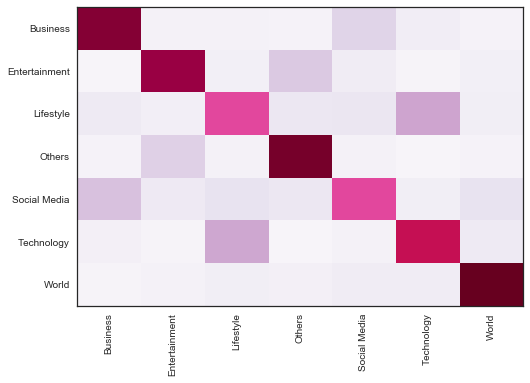

In [91]:
DT_confusion_matrix = confusion_matrix(y_test, y_hat)

cm_normalized = DT_confusion_matrix.astype('float') / DT_confusion_matrix.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()

plt.imshow(cm_normalized, cmap = plt.get_cmap('PuRd'), aspect = 'auto')

ax.set_yticklabels(channels_list)
ax.set_xticklabels(channels_list, rotation = "vertical")

plt.grid(False)

********* TODO interpret the plot above and weights below *** 

In [100]:
# Interpreting weights
zip_varsDT = zip(DTclassifier.feature_importances_.T, df_data_channel.columns) # combine attributes

zip_varsDT = sorted(zip_varsDT)

for importance, name in zip_varsDT:
    print('\t%-35s - importance = %9.3f' % ( name, importance)) # now print them out


	weekday_is_friday                   - importance =     0.000
	weekday_is_thursday                 - importance =     0.000
	weekday_is_monday                   - importance =     0.000
	weekday_is_tuesday                  - importance =     0.000
	weekday_is_wednesday                - importance =     0.000
	ln_abs_title_sentiment_polarity     - importance =     0.000
	title_sentiment_polarity            - importance =     0.000
	abs_title_subjectivity              - importance =     0.001
	n_tokens_title                      - importance =     0.001
	max_negative_polarity               - importance =     0.001
	is_weekend                          - importance =     0.002
	global_rate_positive_words          - importance =     0.002
	min_negative_polarity               - importance =     0.002
	max_positive_polarity               - importance =     0.002
	ln_min_positive_polarity            - importance =     0.002
	ln_global_rate_negative_words       - importance =     0.002
	ln_num_

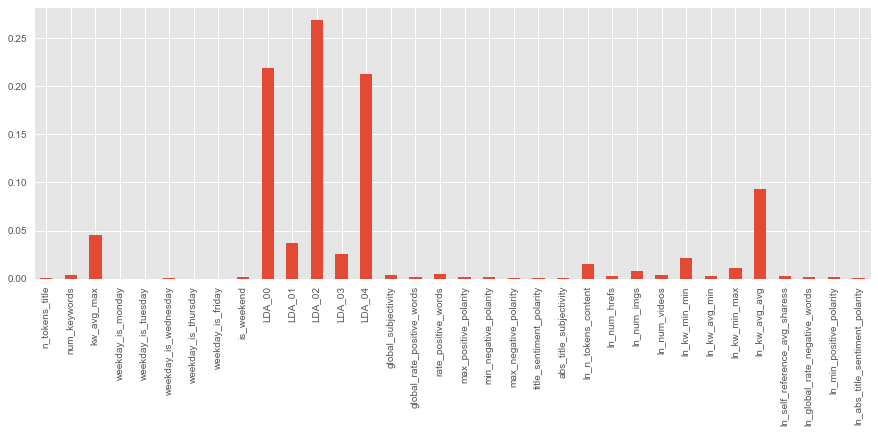

In [98]:
%matplotlib inline
rcParams['figure.figsize'] = 15, 5
plt.style.use('ggplot')

weights = pd.Series(abs(DTclassifier.feature_importances_), index = df_data_channel.columns)
weights.plot(kind = 'bar')
plt.show()

### c. Random Forest Classifier

#### _Grid Search parameter set-up for Random Forest classifier_

In [101]:
RFclf = RandomForestClassifier(
    criterion = 'entropy',
    max_features= 'sqrt',
    max_depth = 5,
    n_estimators = 10,
    n_jobs = -1)

#RFclf.fit(master_X_train, master_y_train)

param_grid =[
    { 
    'criterion': ['gini'],
    'n_estimators': [100, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 50]
},
 { 
    'criterion': ['entropy'],
    'n_estimators': [100, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 50]
}
]

RF_grid_search = GridSearchCV(
    estimator = RFclf,
    param_grid = param_grid,
    cv = 3)

grid_search = RF_grid_search.fit(master_X_train, master_y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

best_criterion = best_parameters['criterion']
best_max_depth = best_parameters['max_depth']
best_max_features = best_parameters['max_features']
best_n_estimators = best_parameters['n_estimators']


#### _best parameters for Random Forest Classifier_

In [102]:
best_accuracy
best_parameters

0.80264858899574332

{'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'log2',
 'n_estimators': 500}

#### _using best parameters for main model for further analysis and model comparison_

In [103]:
from sklearn.ensemble import RandomForestClassifier

tic = time.clock()

# train and test 

RFclf = RandomForestClassifier(
    criterion = best_criterion,
    max_depth = best_max_depth,
    max_features = best_max_features,
    n_estimators = best_n_estimators,
    n_jobs = -1)

RFclf.fit(X_train, y_train)
y_predRF = RFclf.predict(X_test)

# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(y_test, y_predRF))
precision = '{0:.4f}'.format(metrics.precision_score(y_test, y_predRF, average ='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(y_test, y_predRF, average = 'weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(y_test, y_predRF, average = 'weighted'))
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)

# print statistics
print("accuracy",accuracy )
print("precision",precision )
print("recall",recall )
print("f1_score",f1_score )
print("confusion matrix\n", confusion_matrix(y_test, y_predRF))
print('process time',exetime)
print("\n")


# save statistics for model comparison

raw_data = {
    'Model Name':'Random Forest Classifier',
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'FScore':f1_score,
    'Processing Time': exetime
}

df_tbl = pd.DataFrame(raw_data,
        columns = ['Model Name','Accuracy','Precision','Recall','FScore','Processing Time'],
        index = [i_index + 1])

comparison_tbl = comparison_tbl.append(df_tbl)

#append model classifier for cross-validation

models.append(('Random Forest Classifier', RFclf))


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

accuracy 0.8160
precision 0.8108
recall 0.8160
f1_score 0.7972
confusion matrix
 [[ 893   14    0    5   12   31   22]
 [  16  924    2  134    1   26   22]
 [  30    8   39   37   15  183   12]
 [  11   60    4  953    0    6   11]
 [  96   33    2   30  146   33   51]
 [  31   11   10    3    8 1006   67]
 [  17   24    1   28    8   52 1215]]
process time 162.6424




#### heatmap of confusion matrix for Random Forest Classifier

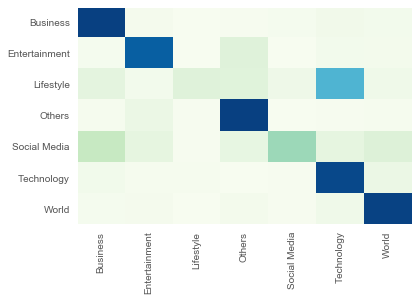

In [106]:
RF_confusion_matrix = confusion_matrix(y_test, y_predRF)

cm_normalized = RF_confusion_matrix.astype('float') / RF_confusion_matrix.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()

plt.imshow(cm_normalized, cmap = plt.get_cmap('GnBu'), aspect = 'auto')

ax.set_yticklabels(channels_list)
ax.set_xticklabels(channels_list, rotation = "vertical")
plt.grid(False)


******* Patrick, write intepretation of above plot and weights below! much appreciated!

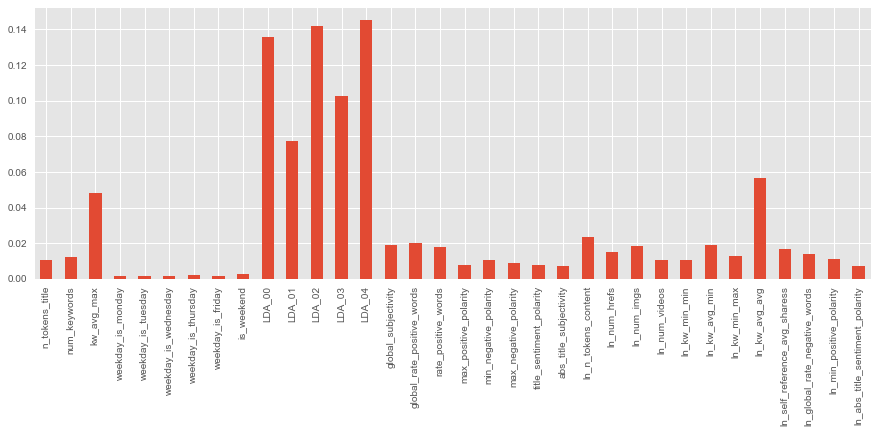

In [107]:
%matplotlib inline
rcParams['figure.figsize'] = 15, 5
plt.style.use('ggplot')

weights = pd.Series(abs(RFclf.feature_importances_), index = df_data_channel.columns)
weights.plot(kind = 'bar')
plt.show()



###  d. Naive Bayes  

 - Evaluate both Mulinomial and Gaussian  
 - Gaussian has only default parameters, so will run grid search only on Multinomial  
 


#### d.1 Multinomial Naive Bayes

In [108]:
from sklearn.naive_bayes import MultinomialNB

MNBclf = MultinomialNB(
    alpha = 0.01,
    class_prior = None,
    fit_prior = True)

params = {
    'alpha':[0.1, 0.5, 1.0]
}

MNB_grid_search = GridSearchCV(
    MNBclf,
    params,
    cv = 3)

grid_search = MNB_grid_search.fit(master_X_train, master_y_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

best_accuracy
best_parameters

best_alpha = best_parameters['alpha']

0.64215670818224813

{'alpha': 0.1}

In [109]:
tic = time.clock()

# train and test 

MNBclf = MultinomialNB(
    alpha = best_alpha,
    class_prior = None,
    fit_prior = True)

MNBclf.fit(X_train, y_train)
y_predMNB = MNBclf.predict(X_test)

# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(y_test, y_predMNB))
precision = '{0:.4f}'.format(metrics.precision_score(y_test, y_predMNB, average ='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(y_test, y_predMNB, average = 'weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(y_test, y_predMNB, average = 'weighted'))
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)

# print statistics
print("accuracy",accuracy )
print("precision",precision )
print("recall",recall )
print("f1_score",f1_score )
print("confusion matrix\n", confusion_matrix(y_test, y_predMNB))
print('process time',exetime)
print("\n")


# save statistics for model comparison

raw_data = {
    'Model Name':'Multinomial Naïve Bayes',
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'FScore':f1_score,
    'Processing Time': exetime
}

df_tbl = pd.DataFrame(raw_data,
        columns = ['Model Name','Accuracy','Precision','Recall','FScore','Processing Time'],
        index = [i_index + 1])

comparison_tbl = comparison_tbl.append(df_tbl)

#append model classifier for cross-validation

models.append(('Multinomial Naïve Bayes', MNBclf))


MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

accuracy 0.6418
precision 0.6234
recall 0.6418
f1_score 0.6248
confusion matrix
 [[ 711   31   58   19   14   76   68]
 [  33  661   41  248   10   65   67]
 [  35   16   35   37    0  167   34]
 [  22  257   44  671    6   31   14]
 [ 120   37   31   43   30   53   77]
 [  49   15   55   15    1  842  159]
 [  29   25   28   24   19   99 1121]]
process time 0.3879




#### heatmap of confusion matrix for Multinomial Naive Bayes Classifier

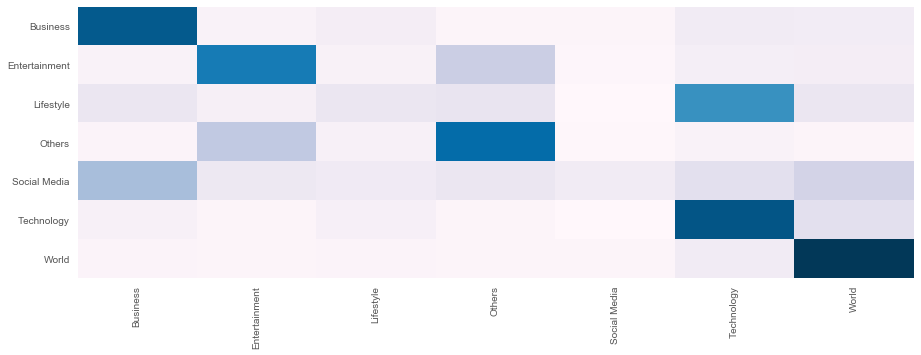

In [110]:
MNB_confusion_matrix = confusion_matrix(y_test, y_predMNB)

cm_normalized = MNB_confusion_matrix.astype('float') / MNB_confusion_matrix.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()

plt.imshow(cm_normalized, cmap = plt.get_cmap('PuBu'), aspect = 'auto')

ax.set_yticklabels(channels_list)
ax.set_xticklabels(channels_list, rotation = "vertical")

plt.grid(False)


********** TODO interpret!!

#### d.2 Gaussian Naive Bayes

In [111]:
from sklearn.naive_bayes import GaussianNB

tic = time.clock()

# train and test 

GNBclf = GaussianNB()

GNBclf.fit(X_train, y_train)
y_predGNB = GNBclf.predict(X_test)

# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(y_test, y_predGNB))
precision = '{0:.4f}'.format(metrics.precision_score(y_test, y_predGNB, average ='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(y_test, y_predGNB, average = 'weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(y_test, y_predGNB, average = 'weighted'))
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)

# print statistics
print("accuracy",accuracy )
print("precision",precision )
print("recall",recall )
print("f1_score",f1_score )
print("confusion matrix\n", confusion_matrix(y_test, y_predGNB))
print('process time',exetime)
print("\n")


# save statistics for model comparison

raw_data = {
    'Model Name':'Gaussian Naïve Bayes',
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'FScore':f1_score,
    'Processing Time': exetime
}

df_tbl = pd.DataFrame(raw_data,
        columns = ['Model Name','Accuracy','Precision','Recall','FScore','Processing Time'],
        index = [i_index + 1])

comparison_tbl = comparison_tbl.append(df_tbl)

#append model classifier for cross-validation

models.append(('Gaussian Naïve Bayes', GNBclf))

GaussianNB(priors=None)

accuracy 0.7241
precision 0.7145
recall 0.7241
f1_score 0.7184
confusion matrix
 [[ 803   16   13    6   70   50   19]
 [   9  822   16  221   27   11   19]
 [  38   12   72   20   12  159   11]
 [   3  192   27  769   46    1    7]
 [ 149   29   26   31   95   19   42]
 [  30   11   98    1   13  907   76]
 [  15   49   11   17   40   88 1125]]
process time 0.1958




#### heatmap of confusion matrix for Gaussian Naive Bayes Classifier

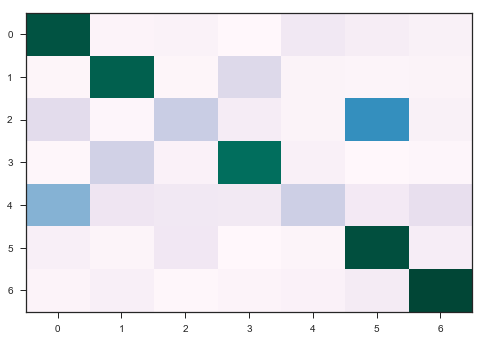

In [126]:
GNB_confusion_matrix = confusion_matrix(y_test, y_predGNB)

cm_normalized = GNB_confusion_matrix.astype('float') / GNB_confusion_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots()

plt.imshow(cm_normalized, cmap = plt.get_cmap('PuBuGn'), aspect = 'auto')

ax.set_yticklabels(channels_list)
ax.set_xticklabels(channels_list, rotation = "vertical")

plt.grid(False)


** TODO Intepret above!

#	Modeling and Evaluation 4

### Evaluation Metrics

In [112]:
# converting acc, pre, recall, fscore and time to numeric values for plots

comparison_tbl = comparison_tbl.reset_index(drop=True)
comparison_tbl['Precision'] = pd.to_numeric(comparison_tbl['Precision'])
comparison_tbl['Accuracy'] = pd.to_numeric(comparison_tbl['Accuracy'])
comparison_tbl['FScore']= pd.to_numeric(comparison_tbl['FScore'])
comparison_tbl['Processing Time'] = pd.to_numeric(comparison_tbl['Processing Time'])
comparison_tbl['Recall'] = pd.to_numeric(comparison_tbl['Recall'])
comparison_tbl


,Model Name,Accuracy,Precision,Recall,FScore,Processing Time
0,Logistic Regression,0.7197,0.7513,0.7197,0.7315,4.6504
1,Logistic Regression,0.7197,0.7513,0.7197,0.7315,4.7239
2,Decision Tree Classifier,0.7662,0.7528,0.7662,0.7555,0.8638
3,Random Forest Classifier,0.8160,0.8108,0.8160,0.7972,162.6424
4,Multinomial Naïve Bayes,0.6418,0.6234,0.6418,0.6248,0.3879
5,Gaussian Naïve Bayes,0.7241,0.7145,0.7241,0.7184,0.1958


#### Visualization of metrics

[None, None, None, None, None, None, None, None, None, None, None, None]

[None, None, None, None, None, None, None, None, None, None, None, None]

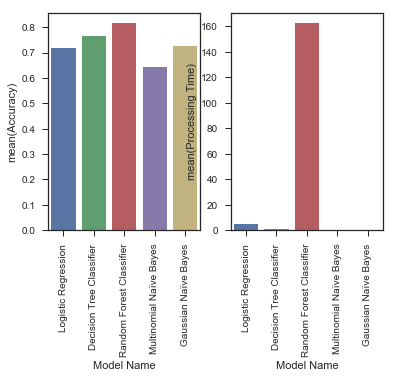

In [115]:
from pylab import rcParams
%matplotlib inline

#comparison_tbl.plot()

fig, axs = plt.subplots(ncols=2)
fig.tight_layout()
plt.setp(axs[0].xaxis.get_majorticklabels(), rotation = 90 )
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation = 90 )

sns.barplot(x = 'Model Name', y = 'Accuracy', data = comparison_tbl, ax = axs[0])

sns.barplot(data = comparison_tbl, y = 'Processing Time', x = 'Model Name', ax = axs[1])



# 10-K Cross-Validation for each classifier
For each classifier we run 10 fold cross validation which will help us narrow down one final model

In [117]:
from sklearn import model_selection

# evaluate each model in turn

results = []
names = []
scoring = 'accuracy'

for name, model in models:
    cv_results = model_selection.cross_val_score(
        model,
        master_X_train,
        master_y_train,
        cv = 10,
        scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "\n\t%-35s mean (std.dev) : %.3f (%.4f)" % (name, cv_results.mean(), cv_results.std())
    #print(cv_results)
    print(msg)

[ 0.70560453  0.72890428  0.71343001  0.71649322  0.72626932  0.7214511
  0.72302839  0.72555205  0.72208202  0.72767435]

	Logistic Regression                : 0.721 (0.0069)


[ 0.70560453  0.72890428  0.71343001  0.71649322  0.72626932  0.7214511
  0.72302839  0.72555205  0.72208202  0.72767435]

	Logistic Regression                : 0.721 (0.0069)


[ 0.75283375  0.76070529  0.76197982  0.76915799  0.76821192  0.7659306
  0.77255521  0.77097792  0.76656151  0.7734301 ]

	Decision Tree Classifier           : 0.766 (0.0060)


[ 0.80478589  0.8063602   0.80359395  0.81677704  0.81803847  0.81324921
  0.80504732  0.81230284  0.80283912  0.81950142]

	Random Forest Classifier           : 0.810 (0.0061)


[ 0.63255668  0.63287154  0.64344262  0.64427625  0.64459161  0.65015773
  0.6466877   0.64321767  0.64511041  0.63426949]

	Multinomial Naïve Bayes            : 0.642 (0.0059)


[ 0.71410579  0.71473552  0.7112232   0.72280038  0.71680858  0.72460568
  0.71608833  0.72902208  0.7189274

## Cross-Validation accuracy comparison of all models

{'boxes': [<matplotlib.lines.Line2D at 0x7f75d6822e80>,
 'caps': [<matplotlib.lines.Line2D at 0x7f75d6833940>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f75d683dc18>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f75d683d3c8>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f75d682c860>,
  <matplotlib.lines.Line2D at 0x7f75d67aeb38>]}

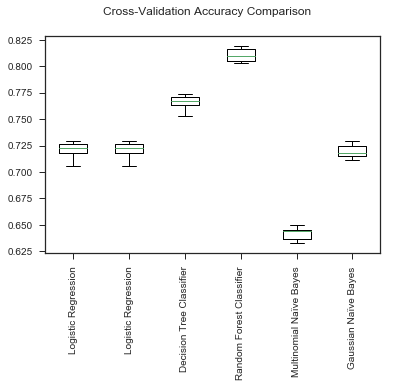

In [120]:
# boxplot accuracy comparison

fig = plt.figure()
fig.suptitle('Cross-Validation Accuracy Comparison')
ax = fig.add_subplot(111)

plt.boxplot(results)

ax.set_xticklabels(names, rotation = 90)
plt.show()


## Holdout test data set prediction with our final model

Our final best model is Random Forest Classifier. We will run prediction on that fit with the test data set we set aside at the beggining of the project. We will calculate statistics for the prediction.

In [121]:
y_predFinal = RFclf.predict(golden_X_test)

# calculate statistics

accuracy = '{0:.4f}'.format(metrics.accuracy_score(golden_y_test, y_predFinal))
precision = '{0:.4f}'.format(metrics.precision_score(golden_y_test, y_predFinal, average ='weighted'))
recall = '{0:.4f}'.format(metrics.recall_score(golden_y_test, y_predFinal, average = 'weighted'))
f1_score = '{0:.4f}'.format(metrics.f1_score(golden_y_test, y_predFinal, average = 'weighted'))
toc =  time.clock()
exetime = '{0:.4f}'.format(toc-tic)

# print statistics
print("accuracy", accuracy )
print("precision", precision )
print("recall", recall )
print("f1_score", f1_score )
print("confusion matrix\n", confusion_matrix(y_test, y_predRF))
print('process time', exetime)
print("\n")


accuracy 0.8219
precision 0.8169
recall 0.8219
f1_score 0.8044
confusion matrix
 [[ 893   14    0    5   12   31   22]
 [  16  924    2  134    1   26   22]
 [  30    8   39   37   15  183   12]
 [  11   60    4  953    0    6   11]
 [  96   33    2   30  146   33   51]
 [  31   11   10    3    8 1006   67]
 [  17   24    1   28    8   52 1215]]
process time 3929.6306




### __Final Statement regarding Task 2 Classifiers

***  

## __Deployment__  

***  

#### Usefulness  

The usefulness of this model is to provide guidance as to which articles are to be published on the mashable.com web-site. One facet of Mashable's business model is to generate revenue by selling advertising and sponsored content on the mashable.com web-site. The value of the site to advertisers, and the revenue stream that can be protected for mashable, can be measured by the number of articles that mashable readers share with their on-line social media network. The value of this classification model is to identify the site content with higher likelihood of being popularly shared within the the target audience. 

#### Measurement of model value  
 
A way to measure the model's value is by monitoring the success of the prediction model in terms of increasing social media shares from mashable published articles. Since there can be many (very many !) factors influencing the popularity (number of shares) of articles that are beyond the applicability scope of the model, it is recommended that the value measurement be assessed by controlled A/B releases of content that is decided by current methods, side-by-side, with content that is recommended with this classification. By using a side-by-side A/B evaluation, the effectiveness of the classification model for improving content recommendations can be credibly assessed.


#### Deployment method / external data support  
 
 The current vision for deployment of the model includes these elements :  
 - a web-based user interface in which the user (the article author or other proposer) can deposit the article (title, content, embedded images and videos) in similar fashion as DropBox or other similar media-sharing file servers  
 - a parsing / feature extraction machine deployed at the shared file server site  
     - the model requires the extraction of several explanatory variables (feature extraction) from the content of the article in order to evaluate the article's popularity score in the model  
         - among the features to be extracted from the article as model inputs are the following :  
             * key-word statistics, positive and negative sentiment counts, LDA_00 --> LDA_04 scores, number of images and number of videos, sentiment polarity based on title, related hyperlink references  
         - a feature extraction machine will be deployed at the file server site to process the article content and provide the model inputs  
         - in addition, another element of the deployment is to assign the article to an appropriate data channel (e.g., Social Media, Technology, Business). this will also be an element deployed on the file server site. the text and title will be processed through a text-mining approach to evaluate the appropriate data channel.  
         
  - once the key features have been developed from the text processing machines, then all of the inputs for the classification model are available and can be executed  
  
  - the concept of the deployment is :  
    * the article is uploaded to the submittal site,  
    * the feature extraction machine is launched, then  
    * the popularity classification model is executed, and  
    * the recommendation to publish or not to publish is provided to the mashable content editor.  
    * the execution time associated to this activity is anticipated to be real-time, within less than a few seconds.  
    
  - the goal of the application is that the article, with only some minimal contextual information (requested publication date, author contact information) is sufficient to provide a __publish / no-publish recommendation__ to the content editor;  
  - the goal is that there is no need for external data gathering to feed the model in the production environment  
  
 
#### Model Updates  

 - this model is intended to estimate the _mashable_ readers' perceptions of what is interesting and relevant to share with their social media network  
 - although the model's basic input features are attempting to capture and use elements that have a certain temporal durability (positive and negative sentiments, domain segregation of vocabulary, hyper-link reference counts) the fact remains that what is popular in this moment is an ever-evolving situation. Because of that, the recommendation is that, at the initial deployment phases, the model characteristics be updated on a monthly basis. Monitoring for evolution of the model charactersitic changes will provide relevant information as to the frequency of updates going forward - either more frequent or less frequent.  
 - longer term, the survivability of this model will be dependent on the ability to deploy this model in a manner that can incorporate reinforcement learning methods. the rapidly evolving nature of what is interesting or not interesting to contemporary society is the heart of the 

        



## Recommendation  

#### - Task 1 - _mashable_ article popularity prediction  

For the __popularity__ classification, we completed an evaluation of 4 different classifier models to identify method to classify an article as likley to be either _popular_ or _not-popular_.

The results of this effort identified that the Random Forest Classifier provided the best overall results. 
The metrics of this classifier are as follows :



# 	Exceptional Work	
We have implemented Grid search in our parament selection process.